# Statistical Analysis of Limited Data to Estimate Magnitude of Fugitive Methane

**This work has been done by Mehdi Rezvandehy, Data scientist at University of Calgary. The results of this work is in process of publication for a scientific journal. Real data set and new developed codes are removed from this script. The completed script will be uploaded when the paper gets published.**

# Introduction

Natural gas (NG) is promoted as a bridge fuel over the coming few decades: it is reviewed as a transitional fuel that allows continued dependence on fossil fuels  with lower greenhouse gas footprint. Exploitation and development of NG has started since last decade and the production rates are increasing due to recent advances in extraction technologies, larger potential resource, close to major markets, relatively inexpensive to produce and depletion of other fossil-fuel solutions in many regions.

Despite the attractive bridge solution of NG, significant monitoring and research should be considered to assess its greenhouse gas (GHG) footprint. Methane (CH4) is the major component of NG and it is a very potent GHG. When the indirect effects of methane on atmospheric aerosols are considered, recent modeling shows that methane has an even greater global warming potential. Methane can be released directly to the atmosphere from leaks at the well production and pipeline facilities, hence questioning its advantage over competing other fossil fuels such as coal. Significant debate is related to the magnitude of the fugitive emissions. Much of the discussions revolves around whether the total release is above or below the cut off of 3.2\%, higher which NG is considered to be worse than coal from a GHG standpoint. So, it is necessary to quantify fugitive emissions from wells, pipelines and facilities over the course of extraction and production. 

There has previously been attempts for detection of fugitive emissions. Mobile measurement approaches apply specialized equipment and procedures for inverse source emission estimation. It quantifies concentration in the crosswind direction as a function of lateral position through the plume. Addressing leakage point sources can be demonstrated as the concentration plume disperses laterally with a Gaussian structure that widens with downwind distance. Point-source Gaussian (PSG), part of Other Test Method (OTM) 33A, is commonly applied to estimate emission rate. This approach  fits a Gaussian dispersion model to the measurements; a look-up table reference of Gaussian dispersion models are constructed based on source distance and an estimate of atmospheric stability; however, estimates of emission rates depends strongly on meteorological conditions during mobile measurement operation. Even the best source-inference techniques work reasonably only under a limited range of dominant wind conditions: the estimated emission rates are usually uncertain due to shifting mean wind speed and direction resulting in instantaneous plume and measurement error (noise and artifact). Inaccurate estimation of true CH4 emission leads to complicate the identification of the most effective CH4 mitigation options for minimizing greenhouse gas emissions. Exhaustive mobile measurement or repetition may lead to more reliable estimation. However, mobile measurements are labour-intensive for use in large oil and gas developments. The main objective of this work is to improve PSG approach for estimation of fugitive gas by considering uncertainty in limited field measurement (uncertainty in wind speed and wind direction).

# Background and Problem Definition 

A synthetic model is considered to estimate leakage rate based on PSG approach. A synthetic Gaussian plume model with constant methane leakage rate of $7 (g/s)$ or $35 (m^{3}/h)$ for stable atmospheric conditions is constructed by python: average wind speed $\approx5(m/s)$, wind direction $\approx45^{\circ}$ and with atmospheric stability indicator of "C". Moreover, it is assumed there is no obstruction in the field. Please see the following python code to see how this model is generated; first an ideal Gaussian plume model is constructed. Then, we randomly sample from the ideal model (say 30000 points) and apply kriging estimation on the samples to make a more reliable model: we may not have constant wind speed and wind direction in real life and there is always a little fluctuation even in a very stable atmospheric condition. Kriging estimation on samples is applied here to produce a smooth fluctuation. We want to estimate leakage rate based on limited mobile measurements. Three vehicle orientations are sampled from the synthetic plume for azimuths $0^{\circ}$, $-45^{\circ}$ and $90^{\circ}$. Leakage rate is estimated based on PSG approach for each orientation.

In [1]:
import os
os.environ['path']+=";.\\Codes"  # All required codes are in this folder
import sys
sys.path.append('./Codes')
from Codes import*
from multiprocessing import Process
import geostatspy.GSLIB as GSLIB                         
import geostatspy.geostats as geostats 
import utm
import numpy as np
import pandas as pd
from matplotlib.legend_handler import HandlerLine2D
import math
from matplotlib.ticker import FuncFormatter, MaxNLocator
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
from IPython.display import Image
from pylab import *
from IPython.core.debugger import Tracer
from numpy import linspace
import matplotlib.mlab as ml
import glob
import statistics
from decimal import *
from matplotlib.font_manager import FontProperties
from statistics import mode 
from IPython.display import clear_output
import numpy.ma as ma
from scipy.optimize import leastsq
import pylab as plt
import matplotlib.gridspec as gridspec
from astropy.modeling import models, fitting
import matplotlib as mpl
import statsmodels.api as sm
import datetime as dt
from matplotlib.path import Path
from matplotlib.patches import PathPatch
from matplotlib import colors
from matplotlib.offsetbox import AnchoredText
import csv
import xlrd
from scipy.optimize import curve_fit
import matplotlib.cm as cm
from IPython.display import HTML
from IPython.display import display, Math, Latex
import xml.etree.ElementTree as ET
import random
from xml.dom import minidom
from matplotlib import colors
import warnings
warnings.filterwarnings('ignore')

## Generate a Theoretical Gaussian Plume

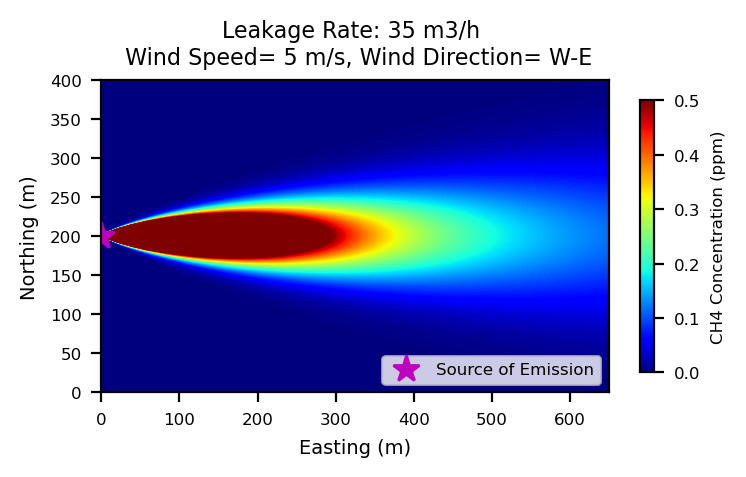

In [3]:
font = {'size'   : 6}
matplotlib.rc('font', **font)
fig, axs = plt.subplots(figsize=(9, 9), dpi= 200, facecolor='w', edgecolor='k')        

Q=7; nx=650; ny=400; Type='C'; Ang=150; U=5;H=0;xsiz=1;xmin=0.5;xshift=0;ysiz=1
ymin=0.5;yshift=ny/2;Trim='False';Tvalue=8
fix,xa,ya,result,Var1a,X_,sigma_y_,sigma_Z_=syn_plume(Q,nx,ny,Type,Ang,U,H,xsiz,xmin,xshift,ysiz,ymin,yshift,Trim,Tvalue)

ax1=subplot(1,2,1)
im = plt.imshow(Var1a, cmap='jet',extent=(0, 650, 0, 400),origin='lower',aspect=1,vmin=0,vmax=0.5)
plt.plot(0,yshift,'m*',markersize=10, label='Source of Emission')
plt.title("Leakage Rate: "+str(int((Q/717)*3600))+" m3/h \n "+"Wind Speed= "+
          str(U)+" m/s, Wind Direction= W-E", fontsize=8.0)  
plt.colorbar(shrink=0.2,label='CH4 Concentration (ppm)') 
plt.legend(loc=4)
plt.xlabel('Easting (m)',fontsize='7')
plt.ylabel('Northing (m)',fontsize='7')
plt.show() 

In [4]:
# Randomly sample some values from theoretical olume
# the samples are dense close to source
random.seed(42)
random_x=[];random_y=[];random_var=[]
tmp=list(range(0, nx*ny, 1))
nrand=30000;random_ran=random.sample(tmp, nrand)
ik1=0;ik2=0;ik3=0;ik4=0;ik5=0;ik6=0
XX=180; YY=200
xrot_0_p=[XX for j in range(16)]
yrot_0_p=[YY+j for j in range(-80,80,10)]

xrot_45_p,yrot_45=rotate(XX,YY,xrot_0_p,yrot_0_p,45)
xrot_45_p_,yrot_45_=rotate(XX,YY,xrot_0_p,yrot_0_p,-45)

dis=3
for j in random_ran:
    ijh=0
    for k in range(len(xrot_0_p)):
        dis1=np.sqrt((xa[j]-xrot_0_p[k])**2+(ya[j]-yrot_0_p[k])**2)
        if(dis1<dis ): ijh=ijh+1
    for k in range(len(xrot_45_p)):
        dis2=np.sqrt((xa[j]-xrot_45_p[k])**2+(ya[j]-yrot_45[k])**2)
        if(dis2<dis): ijh=ijh+1            
    for k in range(len(xrot_45_p_)):
        dis3=np.sqrt((xa[j]-xrot_45_p_[k])**2+(ya[j]-yrot_45_[k])**2)
        if(dis3<dis): ijh=ijh+1           

    if(ijh==0):
        if(xa[j]>0 and xa[j]<50 and ya[j]>150 and ya[j]<250 and ik1<=800):
            random_x.append(xa[j])
            random_y.append(ya[j])
            random_var.append(result[j])
            ik1+=1
        elif(xa[j]>50 and xa[j]<100 and ya[j]>150 and ya[j]<250 and ik2<=700):
            random_x.append(xa[j])
            random_y.append(ya[j])
            random_var.append(result[j])
            ik2+=1   
        elif(xa[j]>=100 and xa[j]<150 and ya[j]>=120 and ya[j]<280 and ik3<=500):
            random_x.append(xa[j])
            random_y.append(ya[j])
            random_var.append(result[j])
            ik3+=1    
        elif(xa[j]>=150 and xa[j]<250 and ya[j]>=120 and ya[j]<280 and ik4<=400):
            random_x.append(xa[j])
            random_y.append(ya[j])
            random_var.append(result[j])
            ik4+=1        
        elif(xa[j]>=250 and xa[j]<350 and ya[j]>=120 and ya[j]<280 and ik5<=200):
            random_x.append(xa[j])
            random_y.append(ya[j])
            random_var.append(result[j])
            ik5+=1          
            
# write down the samples in a file
f1 = open('./synthetic plume/Random_Sample.out', "w");           
n=3; a= 'GSLIB output file'; f1.write(a+"\n"); f1.write(str(n)+"\n") 
a='Easting (m)'; f1.write(a+"\n"); a='Northing (m)'; f1.write(a+"\n") 
a='CH4'; f1.write(a+"\n")    
for ij in range(len(random_x)):
         f1.write("{0:.1f}".format(float(random_x[ij]))+"        "+"{0:.1f}".format(float(random_y[ij]))
          +"        "+"{0:.7f}".format(float(random_var[ij]))+"        "+"\n")
f1.close() 

## Kriging Estimation  

kriging estimation on samples from theoretical plume model.

In [5]:
# Call kt3d GSLIB code in Python for kriging estimation

txt="                  Parameters for KT3D \n"\
+"                  ******************* \n"\
+"START OF PARAMETERS: \n"\
+"./synthetic plume/Random_Sample.out                   -file with data \n"\
+"0  1  2  0  3  0                 -   columns for DH,X,Y,Z,var,sec var \n"\
+"-1.0e21   1.0e21                 -   trimming limits \n"\
+"0                                -option: 0=grid, 1=cross, 2=jackknife \n"\
+"xvk.dat                          -file with jackknife data \n"\
+"1   2   0    3    0              -   columns for X,Y,Z,vr and sec var \n"\
+"3                                -debugging level: 0,1,2,3 \n"\
+"./synthetic plume/kt3d.dbg                         -file for debugging output \n"\
+"./synthetic plume/kt3d.out                         -file for kriged output \n"\
+"650     0.5     1                    - nx,xmn,xsiz \n"\
+"400     0.5     1                    - ny,ymn,ysiz \n"\
+"1      0.5     1                    - nz,zmn,zsiz \n"\
+"1    1      1                    -x,y and z block discretization \n"\
+"4    8                           -min, max data for kriging \n"\
+"0                                -max per octant (0-> not used) \n"\
+"480.0  320.0  1.0                 -maximum search radii \n"\
+"0.0   0.0   0.0                 -angles for search ellipsoid \n"\
+"1    "+str(np.round(np.mean(random_var),4))+   "                     -0=SK,1=OK,2=non-st SK,3=exdrift \n"\
+"0 0 0 0 0 0 0 0 0                -drift: x,y,z,xx,yy,zz,xy,xz,zy \n"\
+"0                                -0, variable; 1, estimate trend \n"\
+"./Output/extdrift.dat                     -gridded file with drift/mean \n"\
+"4                                -  column number in gridded file \n"\
+"1    0.0                               -  nst, nugget effect (Declustered Variogram Model) \n"\
+"1    1.0   90.0   0.0   0.0             -  it,cc,ang1,ang2,ang3 (Declustered Variogram Model) \n"\
+"        480       320       10.170 -  a_hmax,a_hmin,a_vert (Declustered Variogram Model) \n"

f1 = open('temp', "w");
f1.write(txt)
f1.close()

! echo temp | KT3D
! rm temp

clear_output()

In [5]:
# Reading kriging output
txt='./synthetic plume/kt3d.out'   
with open(txt) as f:
    vt1=[]
    for i in range(4):
        next(f)    
    for line in f:
        p = line.split()      
        vt1.append(float(p[0]))         
xa=[]; ya=[]; varkk_Kt3d=[]
kk=0
for j in range(ny):
    for i in range(nx):
        xa.append(xmin+(i)*xsiz)
        ya.append(ymin+(j)*ysiz)            
        index1=i+1 + (j-1+1)*nx 
        varkk_Kt3d.append(vt1[index1-1])
#            
#  Rotate coordinate system
#
Ang=135
xa=[]; ya=[] 
Angle=Ang *(math.pi/180)
for j in range(ny):
    for i in range(nx):
        tmp1=xmin+(i)*xsiz
        tmp2=ymin+(j)*ysiz
        X=(tmp2-yshift)*sin(Angle)+(tmp1-xshift)*cos(Angle)
        xa.append(round(X,0))
        Y=(tmp2-yshift)*cos(Angle)-(tmp1-xshift)*sin(Angle)
        ya.append(round(Y,0))          

## Top-down view of a synthetic Gaussian for Stable Weather Condition

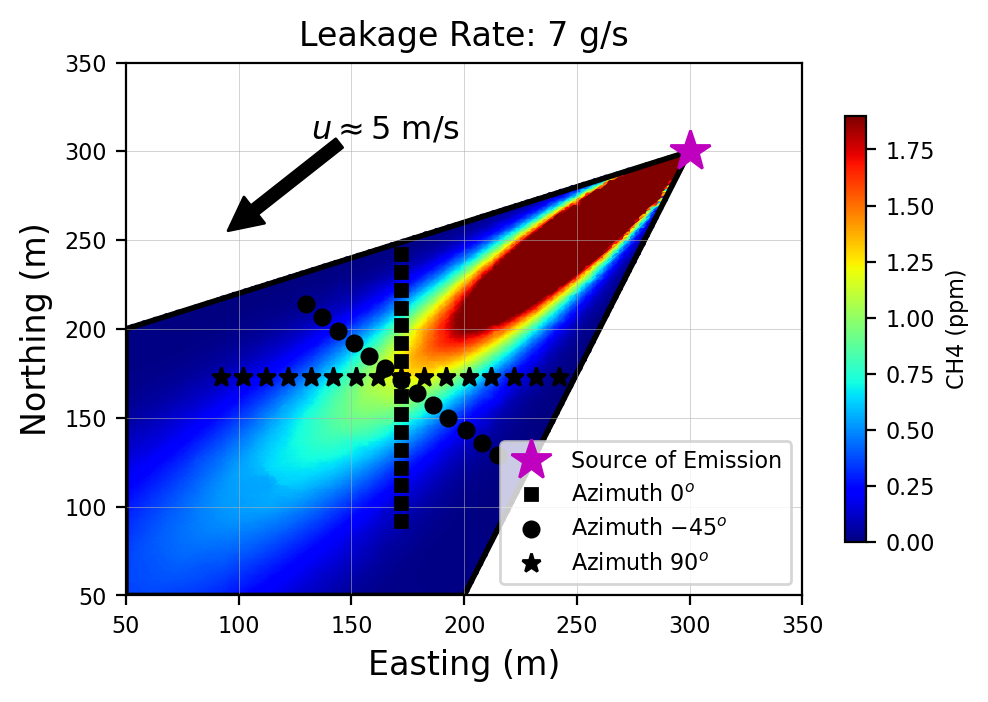

In [6]:
# Plot kriging estimation
fontP = FontProperties()
fontP.set_size('small')
font = {'size'   : 8}
#
matplotlib.rc('font', **font)
fig=plt.figure(figsize=(12, 12), dpi= 200, facecolor='w', edgecolor='k')
#
def Arrow(xstart,ystart,length,Dir):
    if(0<Dir and Dir<90):
        if(Dir<45):
            x=sin((Dir)*(math.pi/180))*length+ xstart
            y=cos((Dir)*(math.pi/180))*length+ ystart
        else:
            x=cos(abs(90-Dir)*(math.pi/180))*length+ xstart            
            y=sin(abs(90-Dir)*(math.pi/180))*length+ ystart
    elif(90<=Dir and Dir<180):
        if(Dir<135):
            x=cos(abs(Dir-90)*(math.pi/180))*length+ xstart            
            y=ystart-sin(abs(Dir-90)*(math.pi/180))*length 
        else:
            x=sin((180-Dir)*(math.pi/180))*length+ xstart
            y=ystart-cos(abs(180-Dir)*(math.pi/180))*length
    elif(180<=Dir and Dir<270):
        if(Dir<225):
            x=xstart-sin(abs(Dir-180)*(math.pi/180))*length
            y=ystart-cos(abs(Dir-180)*(math.pi/180))*length
        else:
            x=xstart-cos(abs(270-Dir)*(math.pi/180))*length
            y=ystart-sin(abs(270-Dir)*(math.pi/180))*length
    elif(270<=Dir and Dir<360):
        if(Dir<315):
            x=xstart-cos(abs(270-Dir)*(math.pi/180))*length            
            y=sin(abs(270-Dir)*(math.pi/180))*length+ ystart
        else:
            x=xstart-sin(abs(360-Dir)*(math.pi/180))*length
            y=cos(abs(360-Dir)*(math.pi/180))*length+ ystart                      
    return x,y  
#
vmin=min(result); vmax=max(result) 
ax1=plt.subplot(3,2,1)

x_o=300;y_o=300

plt.title("Leakage Rate: "+str(Q)+" g/s",fontsize='12')
plt.xlim((50, 350))   
plt.ylim((50, 350))   
plt.grid(linewidth=0.2)
plt.plot(x_o,y_o,'m*',markersize=15, label='Source of Emission')

#
Final=varkk_Kt3d
filt=0.009
a=np.array([int(x+x_o) for x in xa])
b=np.array([int(x+y_o) for x in ya])
#
path=(50,200),(300,300),(200,50),(50,50),(50,200)
path1 = np.asarray(path)
path2 = Path(path1)
patch = PathPatch(path2, facecolor='none',linewidth=2)

a1=[a[x] for x in range(len(a)) if (path2.contains_points([(a[x],b[x])]))[0]]        
b1=[b[x] for x in range(len(b)) if (path2.contains_points([(a[x],b[x])]))[0]]        
c1=[Final[x] for x in range(len(b)) if (path2.contains_points([(a[x],b[x])]))[0]]

plt.scatter(a1,b1,c=c1,s=2,cmap='jet',vmin=vmin,vmax=1.9)  
plt.gca().add_patch(patch)

XX=300-180*cos(45 *(math.pi/180))
YY=300-180*sin(45 *(math.pi/180))
xrot_0_p=[XX for j in range(16)]
yrot_0_p=[YY+j for j in range(-80,80,10)]

ic_0_p=[]
for i in range(len(xrot_0_p)):
    value=xrot_0_p[i],yrot_0_p[i]
    array=[(a[j],b[j]) for j in range(len(a))]
    idx=find_nearest(array, value)
    ic_0_p.append(Final[idx])             

xrot_0_p=[int(xrot_0_p[x]) for x in range(len(xrot_0_p)) if ic_0_p[x]>filt]  
yrot_0_p=[int(yrot_0_p[x]) for x in range(len(yrot_0_p)) if ic_0_p[x]>filt] 
ic_0_p=[ic_0_p[x] for x in range(len(ic_0_p)) if ic_0_p[x]>filt]     
plt.plot(xrot_0_p,yrot_0_p,'ks',markersize=4.5,linewidth=3,label='Azimuth '+r'$0^{o}$')
#
xrot_45_p,yrot_45=rotate(XX,YY,xrot_0_p,yrot_0_p,-45)
ic_45_p=[]
for i in range(len(xrot_45_p)):
    value=xrot_45_p[i],yrot_45[i]
    array=[(a[j],b[j]) for j in range(len(a))]
    idx=find_nearest(array, value)
    ic_45_p.append(Final[idx])             

xrot_45_p=[int(xrot_45_p[x]) for x in range(len(xrot_45_p)) if ic_45_p[x]>filt]  
yrot_45=[int(yrot_45[x]) for x in range(len(yrot_45)) if ic_45_p[x]>filt] 
ic_45_p=[ic_45_p[x] for x in range(len(ic_45_p)) if ic_45_p[x]>filt]      
plt.plot(xrot_45_p,yrot_45,'ko',markersize=5.5,linewidth=3,label='Azimuth '+r'$-45^{o}$')
#
xrot_90_p,yrot_90_p=rotate(XX,YY,xrot_0_p,yrot_0_p,90)
ic_90_p=[]
for i in range(len(xrot_90_p)):
    value=xrot_90_p[i],yrot_90_p[i]
    array=[(a[j],b[j]) for j in range(len(a))]
    idx=find_nearest(array, value)
    ic_90_p.append(Final[idx])             

xrot_90_p=[int(xrot_90_p[x]) for x in range(len(xrot_90_p)) if ic_90_p[x]>filt]  
yrot_90_p=[int(yrot_90_p[x]) for x in range(len(yrot_90_p)) if ic_90_p[x]>filt] 
ic_90_p=[ic_90_p[x] for x in range(len(ic_90_p)) if ic_90_p[x]>filt]     
plt.plot(xrot_90_p,yrot_90_p,'k*',markersize=7,linewidth=3,label='Azimuth '+r'$90^{o}$')

xstart=150;ystart=310;length=85
x_,y_=Arrow(xstart,ystart,length,Ang-90+180)
ax1.text(xstart+15, ystart+2, r'$u\approx$'+'5 m/s', size=11.5, ha='center', va='center') 
ax1.annotate('',xy=(x_,y_), xytext=(xstart, ystart),
             arrowprops=dict(facecolor='black',shrink=0.09),)

plt.xlabel('Easting (m)',fontsize='12')
plt.ylabel('Northing (m)',fontsize='12')
plt.colorbar(shrink=0.8,label='CH4 (ppm)')  
plt.legend(loc=4) 
#fig.savefig('Ideal Gaussian_with Kriging.png', bbox_inches='tight',dpi=600)
plt.show()

### Concentration Profile for Azimuth 0, -45 and 90

Figure below shows concentration profiles for azimuths $0^{\circ}$, $-45^{\circ}$, $90^{\circ}$. Azimuth $-45^{\circ}$ is completely Gaussian since it is perpendicular to the centerline of the Gaussian plume model while azimuths $-45^{\circ}$ and $90^{\circ}$ have a little deviation from a Gaussian model. For estimation of leakage rate by PSG approach, only peak concentration ($C_{m}$) of traversing the plume is required. Due to noise and uncertainty in measurement, it is more reliable to achieve peak concentration from a fitted Gaussian model to concentration profile than simply find the maximum value of data. The calculated peak concentration (from fitted Gaussian model) for all azimuths are close to real peak concentration (red dashed line). 

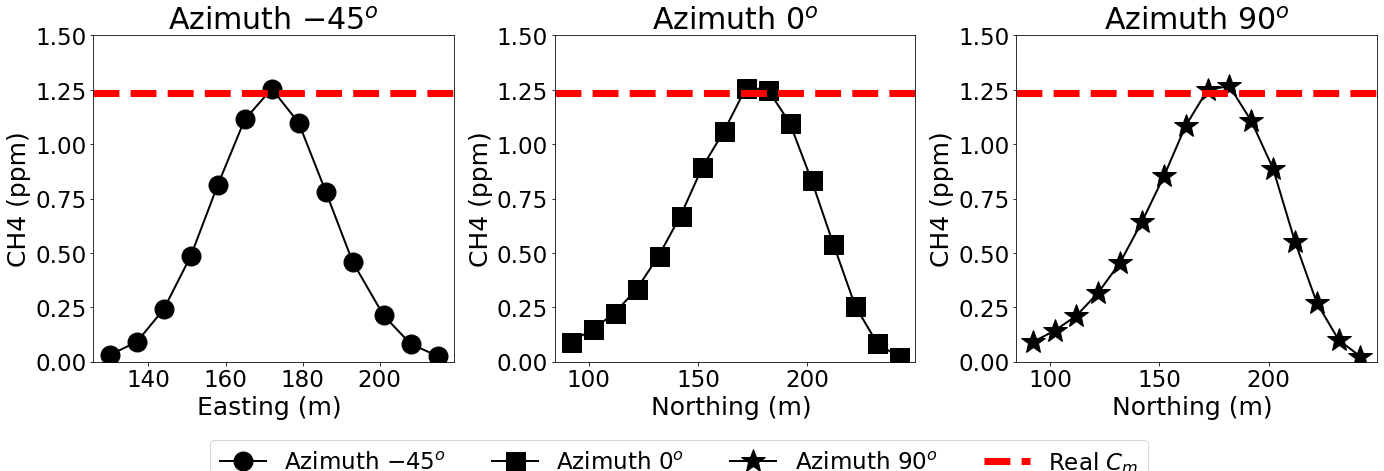

In [7]:
font = {'size'   : 23}
matplotlib.rc('font', **font)

fig, axs = plt.subplots(figsize=(23, 6), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.0, wspace=0.28)
#  
for i in range(3):
    ax1=plt.subplot(1,3,i+1)
    if(i==0):
        plt.plot(xrot_45_p,ic_45_p,'k-o',linewidth='2',markersize=19,label='Azimuth '+r'$-45^{o}$')
        plt.xlabel('Easting (m) ',fontsize='25')
        plt.ylabel('CH4 (ppm)',fontsize='25') 
        plt.axhline(fix, ls='--',linewidth=7,color='r')
        plt.ylim((0, 1.5))
        plt.title('Azimuth '+r'$-45^{o}$',fontsize='30')
    #   
    if(i==1):
        plt.plot(yrot_0_p,ic_0_p,'k-s',linewidth='2',markersize=19,label='Azimuth '+r'$0^{o}$')
        plt.xlabel('Northing (m) ',fontsize='25')
        plt.ylabel('CH4 (ppm)',fontsize='25') 
        plt.axhline(fix, ls='--',linewidth=7,color='r')
        plt.ylim((0, 1.5)) 
        plt.title('Azimuth '+r'$0^{o}$',fontsize='30')
    #
    if(i==2):
        plt.plot(xrot_90_p,ic_90_p,'k-*',linewidth='2.0',markersize=25,label='Azimuth '+r'$90^{o}$')
        plt.xlabel('Northing (m) ',fontsize='25')
        plt.ylabel('CH4 (ppm)',fontsize='25') 
        plt.axhline(fix, ls='--',linewidth=7,color='r',label='Real '+r'$C_{m}$')
        plt.ylim((0, 1.5))  
        plt.title('Azimuth '+r'$90^{o}$',fontsize='30')
    #   
text = fig.text(0.7,-0.1, " ")    
fig.legend(loc=0,ncol=5,bbox_to_anchor=(0.7,0.099))    
#plt.savefig('Profile_Ideal_Con.pdf',dpi=600)
plt.show()

### Fit Gaussian Models for Azimuths $0^{\circ}$, $-45^{\circ}$ and $90^{\circ}$

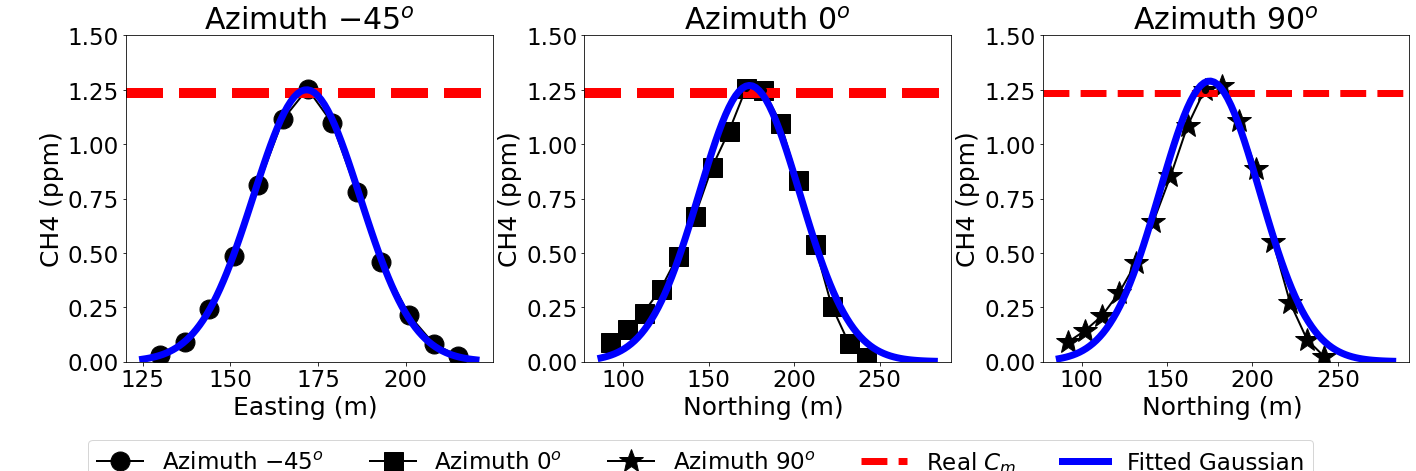

In [8]:
font = {'size'   : 23}
matplotlib.rc('font', **font)

fig, axs = plt.subplots(figsize=(23, 6), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.1, wspace=0.25)
########################################################################################  
ax1=plt.subplot(1,3,1)
plt.plot(xrot_45_p,ic_45_p,'k-o',linewidth='2',markersize=19,label='Azimuth '+r'$-45^{o}$')
plt.xlabel('Easting (m) ',fontsize='25')
plt.ylabel('CH4 (ppm)',fontsize='25') 
plt.axhline(fix, ls='--',linewidth=10.0,color='r')
plt.ylim((0, 1.5)) 
xx=xrot_45_p
yy=ic_45_p
n=len(xx)
mean = sum(xx)/n
sigma=sum(xx-mean)**2/n

# Fit the data using a Gaussian
g_init = models.Gaussian1D(amplitude=0.1, mean=mean, stddev=mean)
fit_g = fitting.LevMarLSQFitter()
g = fit_g(g_init, xx, yy)

# Plot the data with the best-fit model
plt.plot(xx, yy, 'ko')
xx1=np.linspace(min(xx)-5,max(xx)+5, num=100)
plt.plot(xx1, (g(xx1)/max(g(xx1)))*1.25,'b',linewidth=7)    
Cm_45=1.25
plt.title('Azimuth '+r'$-45^{o}$',fontsize='30')
########################################################################################  
ax1=plt.subplot(1,3,2)
plt.plot(yrot_0_p,ic_0_p,'k-s',linewidth='2',markersize=19,label='Azimuth '+r'$0^{o}$')
plt.xlabel('Northing (m) ',fontsize='25')
plt.ylabel('CH4 (ppm)',fontsize='25') 
plt.axhline(fix, ls='--',linewidth=10,color='r')
plt.ylim((0, 1.5))   # set the xlim to xmin, xmax
xx=yrot_0_p
yy=ic_0_p
n=len(xx)
mean = sum(xx)/n
sigma=sum(xx-mean)**2/n

# Fit the data using a Gaussian
g_init = models.Gaussian1D(amplitude=0.1, mean=mean, stddev=mean)
fit_g = fitting.LevMarLSQFitter()
g = fit_g(g_init, xx, yy)

# Plot the data with the best-fit model
plt.plot(xx, yy, 'ko')
xx1=np.linspace(min(xx)-5,max(xx)+40, num=100)
plt.plot(xx1, (g(xx1)/max(g(xx1)))*1.27,'b',linewidth=7) 
Cm_0=1.27
plt.title('Azimuth '+r'$0^{o}$',fontsize='30')
########################################################################################  
ax1=plt.subplot(1,3,3)
plt.plot(xrot_90_p,ic_90_p,'k-*',linewidth='2.0',markersize=25,label='Azimuth '+r'$90^{o}$')
plt.xlabel('Northing (m) ',fontsize='25')
plt.ylabel('CH4 (ppm)',fontsize='25') 
plt.axhline(fix, ls='--',linewidth=7,color='r',label='Real '+r'$C_{m}$')
plt.ylim((0, 1.5))
xx=xrot_90_p
yy=ic_90_p
n=len(xx)
mean = sum(xx)/n
sigma=sum(xx-mean)**2/n

# Fit the data using a Gaussian
g_init = models.Gaussian1D(amplitude=0.1, mean=mean, stddev=mean)
fit_g = fitting.LevMarLSQFitter()
g = fit_g(g_init, xx, yy)

# Plot the data with the best-fit model
plt.plot(xx, yy, 'ko')
xx1=np.linspace(min(xx)-5,max(xx)+40, num=100)
plt.plot(xx1, (g(xx1)/max(g(xx1)))*1.29,'b',linewidth=7, label='Fitted Gaussian')  
Cm_90=1.29
plt.title('Azimuth '+r'$90^{o}$',fontsize='30')
text = fig.text(0.7,-0.1, " ")
fig.legend(loc=0,ncol=5,bbox_to_anchor=(0.8,0.099))   
#fig.savefig('Profile_Ideal_WS.pdf', bbox_inches='tight',dpi=600)
plt.show()

### Estimation of Emission Rate for Azimuths $0^{\circ}$, $-45^{\circ}$ and $90^{\circ}$

Figure below shows the result of PSG estimation ($S_{PSG}$) for azimuths $0^{\circ}$, $-45^{\circ}$ and $90^{\circ}$. Since this synthetic model is generated for stable weather condition, estimations are close to real leakage rate ($Real$ $S_{PSG}=$7.0 $g/s$ = 843 $m^{3}/day$). The lowest error (1.43 \%) is for azimuth $-45^{\circ}$ since it is completely perpendicular to the centerline of the plume and the fitted Gaussian model can accurately estimate $C_{m}$. It may be higher error for estimation of leakage rate by PSG approach even in case of stable wind if the orientation of measurements is not perpendicular to the centerline of the plume. The higher the difference from perpendicularity, the more error we should expect to have. This example is an uncommon case of Gaussian plume in real life that meteorological situation is stable: constant wind speed and wind direction. In practice, it is likely to have unstable atmospheric conditions for example instantaneous change of wind speed and wind direction. 

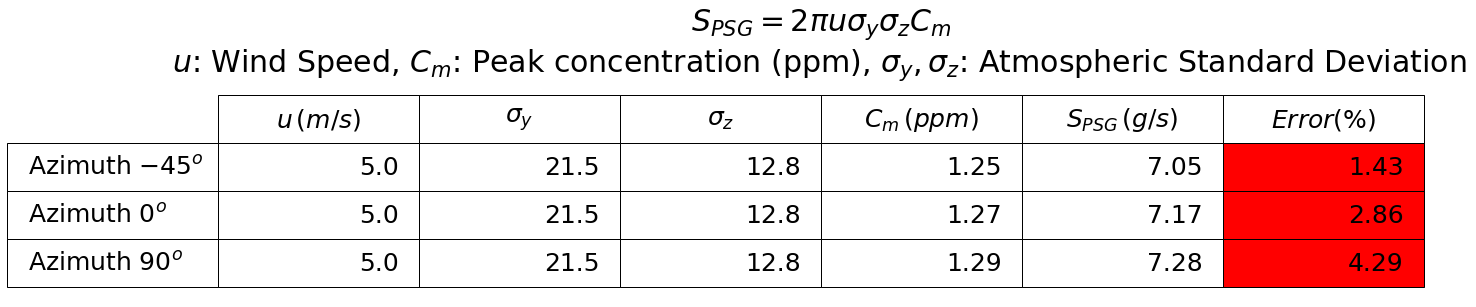

In [9]:
font = {'size'   : 25}
matplotlib.rc('font', **font)

columns = (r'$u \,(m/s)$', r'$\sigma_{y}$', r'$\sigma_{z}$', r'$C_{m}\,(ppm)$', r'$S_{PSG}\,(g/s)$', r'$Error (\%)$')
rows = ['Azimuth '+r'$-45^{o}$', 'Azimuth '+r'$0^{o}$', 'Azimuth '+r'$90^{o}$']

data_list=zeros((3,6))
a1=5;a2=5;a3=5
data_list[0,0]=round(a1,2) ; data_list[1,0]=round(a2,2); data_list[2,0]=round(a3,2)
data_list[:,1]=round(sigma_y_,1) ; data_list[:,2]=round(sigma_Z_,1)
data_list[0,3]=round(Cm_45,2) ; data_list[1,3]=round(Cm_0,2) ;data_list[2,3]=round(Cm_90,2) 
data_list[0,4]=np.round((2*np.pi*a1*sigma_y_*sigma_Z_*(16*Cm_45/24.45)*10**-3) ,2)
data_list[0,5]=np.round(((np.round((2*np.pi*a1*sigma_y_*sigma_Z_*(16*Cm_45/24.45)*10**-3) ,1)-7.)/7)*100,2)
data_list[1,4]=np.round((2*np.pi*a2*sigma_y_*sigma_Z_*(16*Cm_0/24.45)*10**-3),2)
data_list[1,5]=np.round(((np.round((2*np.pi*a2*sigma_y_*sigma_Z_*(16*Cm_0/24.45)*10**-3) ,1)-7.)/7)*100,2)
data_list[2,4]=np.round((2*np.pi*a3*sigma_y_*sigma_Z_*(16*Cm_90/24.45)*10**-3) ,2)
data_list[2,5]=np.round(((np.round((2*np.pi*a3*sigma_y_*sigma_Z_*(16*Cm_90/24.45)*10**-3) ,1)-7.)/7)*100,2)
ytable =plt.table(cellText=data_list,rowLabels=rows,colLabels=columns, loc="center",
          colWidths=[0.6 for x in columns])
plt.title(r"$S_{PSG}=2\pi u \sigma_{y}\sigma_{z}C_{m} \,\,\,\,\,\,\,\,\,\,\,\,$"+'\n'+
          r"$u$"+ ": Wind Speed, "+r"$ C_{m}$"+ ": Peak concentration (ppm), "+
         '$\sigma_{y},\sigma_{z}$'+ ": Atmospheric Standard Deviation ")
plt.axis("off")
ytable._cells[(1, 5)].set_facecolor("r");ytable._cells[(2, 5)].set_facecolor("r")
ytable._cells[(3, 5)].set_facecolor("r")
ytable.scale(1, 4)

plt.show()

## Unstable Wind Direction

Another synthetic model is generated for unstable atmospheric conditions with constant methane leakage rate of $7 (g/s)$. The wind speed fluctuates very smoothly around $\approx5(m/s)$ with atmospheric stability indicator of "C", but the wind direction changes a lot albeit the major direction azimuth is $\approx45^{\circ}$. We make an ideal Gaussian plume model and randomly sample data from the model (say 3000 points). Then, sequential Gaussian simulation (SGS) is applied instead of kriging estimation to simulate spatially correlated heterogeneity. The spatial correlation (or variogram) of SGS is assumed omni-directional that leads to mimic a simulation realization in case of non-constant wind direction with stochastic heterogeneity if we had one snap-shop top-down view. 

In [221]:
# Parameter file of SGS
for isim in range(7):
    txt="                 Parameters for SGSIM \n"\
    +"                      ********************** \n"\
    +"START OF PARAMETERS:\n"\
    +"./synthetic plume/Random_Sample.out              -file with data\n"\
    +"1  2  0  3  0  0              -  columns for X,Y,Z,vr,wt,sec.var.\n"\
    +"-998.0       1.0e21           -  trimming limits\n"\
    +"1                             -transform the data (0=no, 1=yes)\n"\
    +"./synthetic plume/sgsim.trn                     -  file for output trans table\n"\
    +"0                             -  consider ref. dist (0=no, 1=yes)\n"\
    +"./synthetic plume/SB_                 -  file with ref. dist distribution\n"\
    +"1  0                          -  columns for vr and wt\n"\
    +str(min(random_var))+"    "+str(max(random_var))+"     -  zmin,zmax (for tail extrapolation)\n"\
    +"1       4.0                   -  lower tail option (1=linear), parameter\n"\
    +"1      11.5                   -  upper tail option (1=linear), parameter\n"\
    +"1                             -debugging level: 0,1,2,3\n"\
    +"./synthetic plume/Random.dbg                     -file for debugging output\n"\
    +"./synthetic plume/Random_SGS_"+str(isim+1)+"                    -file for simulation output\n"\
    +"1                            -number of realizations to generate\n"\
    +"650   0.5   1                  -nx,xmn,xsiz\n"\
    +"400   0.5   1                -ny,ymn,ysiz\n"\
    +"1    1    1                     -nz,zmn,zsiz\n"\
    +str(60780+isim)+"                      -random number seed\n"\
    +"0     24                      -min and max original data for sim\n"\
    +"24                            -number of simulated nodes to use\n"\
    +"0                             -assign data to nodes (0=no, 1=yes)\n"\
    +"1     3                       -multiple grid search (0=no, 1=yes),num\n"\
    +"0                             -maximum data per octant (0=not used)\n"\
    +"80  80  1.0                 -maximum search radii\n"\
    +"0   0.0   0.0                 -angles for search ellipsoid\n"\
    +"0    0.60   1.0              -ktype: 0=SK,1=OK,2=LVM,3=EXDR,4=COLC, corr and VRF\n"\
    +"lvmfl.dat                     -  file with LVM, EXDR, or COLC variable\n"\
    +"1                             -  column for secondary variable\n"\
    +"1    0.00                      -nst, nugget effect\n"\
    +"1    1  0.0   0.0   0.0     -it,cc,ang1,ang2,ang3\n"\
    +"         180.0  180.0  4.0     -a_hmax, a_hmin, a_vert\n"
    #
    f1 = open('temp', "w");
    f1.write(txt)
    f1.close()
    
    ! echo temp | sgsim
    ! rm temp

clear_output()

In [10]:
# Reading simulated data
txt='./synthetic plume/Random_SGS_1'   
with open(txt) as f:
    vt1=[]
    for i in range(3):
        next(f)    
    for line in f:
        p = line.split()      
        vt1.append(float(p[0]))         
xa=[];ya=[];varkk_real=[]
for j in range(ny):
    for i in range(nx):
        xa.append(xmin+(i)*xsiz)
        ya.append(ymin+(j)*ysiz)            
        index1=i+1 + (j-1+1)*nx 
        varkk_real.append(vt1[index1-1])
#            
#  Rotate coordinate system
#
Ang=135; xa=[]; ya=[] 
Angle=Ang *(math.pi/180)
for j in range(ny):
    for i in range(nx):
        tmp1=xmin+(i)*xsiz
        tmp2=ymin+(j)*ysiz
        X=(tmp2-yshift)*sin(Angle)+(tmp1-xshift)*cos(Angle)
        xa.append(round(X,0))
        Y=(tmp2-yshift)*cos(Angle)-(tmp1-xshift)*sin(Angle)
        ya.append(round(Y,0))  

## Top-down View of a Synthetic Gaussian Plume for Unstable Weather Condition

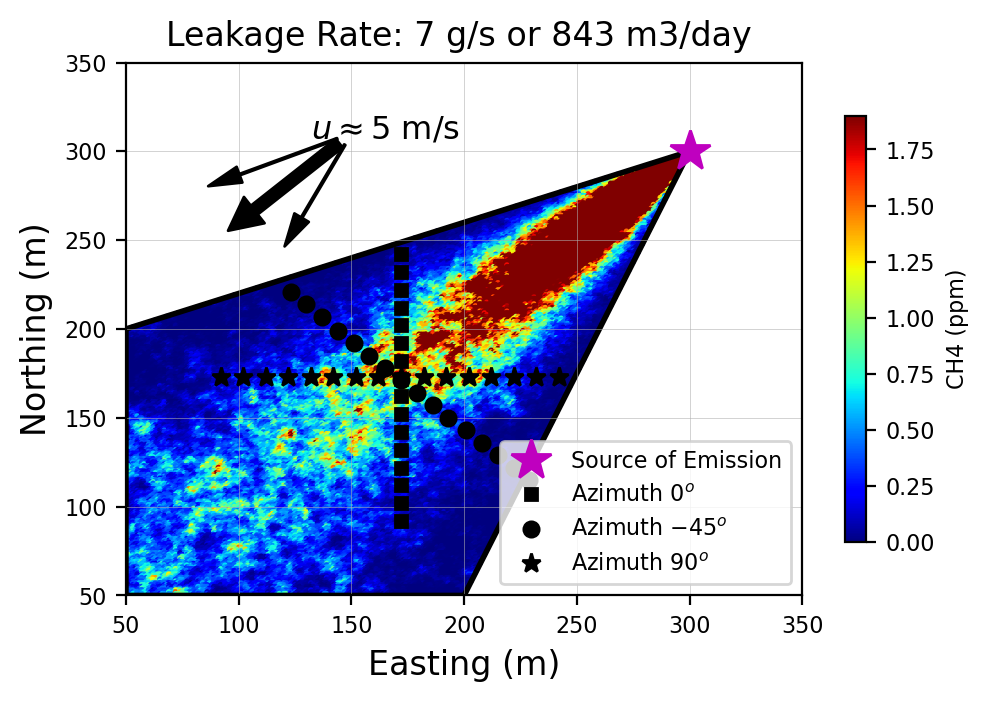

In [11]:
fontP = FontProperties()
fontP.set_size('small')
font = {'size'   : 8}
#
matplotlib.rc('font', **font)
fig=plt.figure(figsize=(12, 12), dpi= 200, facecolor='w', edgecolor='k')
vmin=min(result); vmax=max(result); x_o=300;y_o=300

ax1=plt.subplot(3,2,1)
plt.title("Leakage Rate: "+str(Q)+" g/s or "+str(int((Q/717)*3600*24))+" m3/day ",
          fontsize='12')
plt.xlim((50, 350))  
plt.ylim((50, 350))  
plt.grid(linewidth=0.2)
plt.plot(x_o,y_o,'m*',markersize=15, label='Source of Emission')
Final=varkk_real
filt=0.00
a=np.array([int(x+x_o) for x in xa])
b=np.array([int(x+y_o) for x in ya])

path=(50,200),(300,300),(200,50),(50,50),(50,200)
path1 = np.asarray(path)
path2 = Path(path1)
patch = PathPatch(path2, facecolor='none',linewidth=2)

a1=[a[x] for x in range(len(a)) if (path2.contains_points([(a[x],b[x])]))[0]]        
b1=[b[x] for x in range(len(b)) if (path2.contains_points([(a[x],b[x])]))[0]]        
c1=[Final[x] for x in range(len(b)) if (path2.contains_points([(a[x],b[x])]))[0]]

plt.scatter(a1,b1,c=c1,s=1,cmap='jet',vmin=vmin,vmax=1.9)  
plt.gca().add_patch(patch)

XX=300-180*cos(45 *(math.pi/180))
YY=300-180*sin(45 *(math.pi/180))
xrot_0_p=[XX for j in range(16)]
yrot_0_p=[YY+j for j in range(-80,80,10)]

ic_0_p=[]
for i in range(len(xrot_0_p)):
    value=xrot_0_p[i],yrot_0_p[i]
    array=[(a[j],b[j]) for j in range(len(a))]
    idx=find_nearest(array, value)
    ic_0_p.append(Final[idx])           

xrot_0_p=[int(xrot_0_p[x]) for x in range(len(xrot_0_p)) if ic_0_p[x]>filt]  
yrot_0_p=[int(yrot_0_p[x]) for x in range(len(yrot_0_p)) if ic_0_p[x]>filt] 
ic_0_p=[ic_0_p[x] for x in range(len(ic_0_p)) if ic_0_p[x]>filt] 

plt.plot(xrot_0_p,yrot_0_p,'ks',markersize=4.5,linewidth=3,label='Azimuth '+r'$0^{o}$')

xrot_45_p,yrot_45=rotate(XX,YY,xrot_0_p,yrot_0_p,-45)
ic_45_p=[]
for i in range(len(xrot_45_p)):
    value=xrot_45_p[i],yrot_45[i]
    array=[(a[j],b[j]) for j in range(len(a))]
    idx=find_nearest(array, value)
    ic_45_p.append(Final[idx])             

xrot_45_p=[int(xrot_45_p[x]) for x in range(len(xrot_45_p)) if ic_45_p[x]>filt]  
yrot_45=[int(yrot_45[x]) for x in range(len(yrot_45)) if ic_45_p[x]>filt] 
ic_45_p=[ic_45_p[x] for x in range(len(ic_45_p)) if ic_45_p[x]>filt]     
    
plt.plot(xrot_45_p,yrot_45,'ko',markersize=5.5,linewidth=3,label='Azimuth '+r'$-45^{o}$')

xrot_90_p,yrot_90_p=rotate(XX,YY,xrot_0_p,yrot_0_p,90)
ic_90_p=[]
for i in range(len(xrot_90_p)):
    value=xrot_90_p[i],yrot_90_p[i]
    array=[(a[j],b[j]) for j in range(len(a))]
    idx=find_nearest(array, value)
    ic_90_p.append(Final[idx])             

xrot_90_p=[int(xrot_90_p[x]) for x in range(len(xrot_90_p)) if ic_90_p[x]>filt]  
yrot_90_p=[int(yrot_90_p[x]) for x in range(len(yrot_90_p)) if ic_90_p[x]>filt] 
ic_90_p=[ic_90_p[x] for x in range(len(ic_90_p)) if ic_90_p[x]>filt]     
    
plt.plot(xrot_90_p,yrot_90_p,'k*',markersize=7,linewidth=3,label='Azimuth '+r'$90^{o}$')

xstart=150;ystart=310;length=85
x_,y_=Arrow(xstart,ystart,length,Ang-90+180) 
ax1.text(xstart+15, ystart+2, r'$u\approx$'+'5 m/s', size=11.5, ha='center', va='center')
ax1.annotate('',xy=(x_,y_), xytext=(xstart, ystart),
             arrowprops=dict(facecolor='black',shrink=0.09),)
xstart=150;ystart=310;length=77
x_,y_=Arrow(xstart,ystart,length,Ang-90+180+20)
ax1.text(xstart+15, ystart+2,'', size=13, ha='center', va='center')   
ax1.annotate('',xy=(x_,y_), xytext=(xstart, ystart),
             arrowprops=dict(width=0.5,headwidth=6,facecolor='black',shrink=0.09),)
x_,y_=Arrow(xstart,ystart,length,Ang-90+180-20)
ax1.text(xstart+15, ystart+2, '', size=13, ha='center', va='center')   
ax1.annotate('',xy=(x_,y_), xytext=(xstart, ystart),
             arrowprops=dict(width=0.5,headwidth=6,facecolor='black',shrink=0.09),)
plt.xlabel('Easting (m)',fontsize='12')
plt.ylabel('Northing (m)',fontsize='12')
plt.colorbar(shrink=0.8,label='CH4 (ppm)')  
plt.legend(loc=4) 
plt.show()
#fig.savefig('Nonconstant_ wind_direction.png', bbox_inches='tight',dpi=600)

Figure below shows concentration profiles for azimuths $0^{\circ}$, $-45^{\circ}$, $90^{\circ}$. In comparison with the plume for stable weather condition, concentration profiles are unstable and noisy. For estimation of the leakage rate, it may be possible to fit a Gaussian model to concentration values with minimum. 

### Concentration Profile for Azimuth 0, -45 and 90 

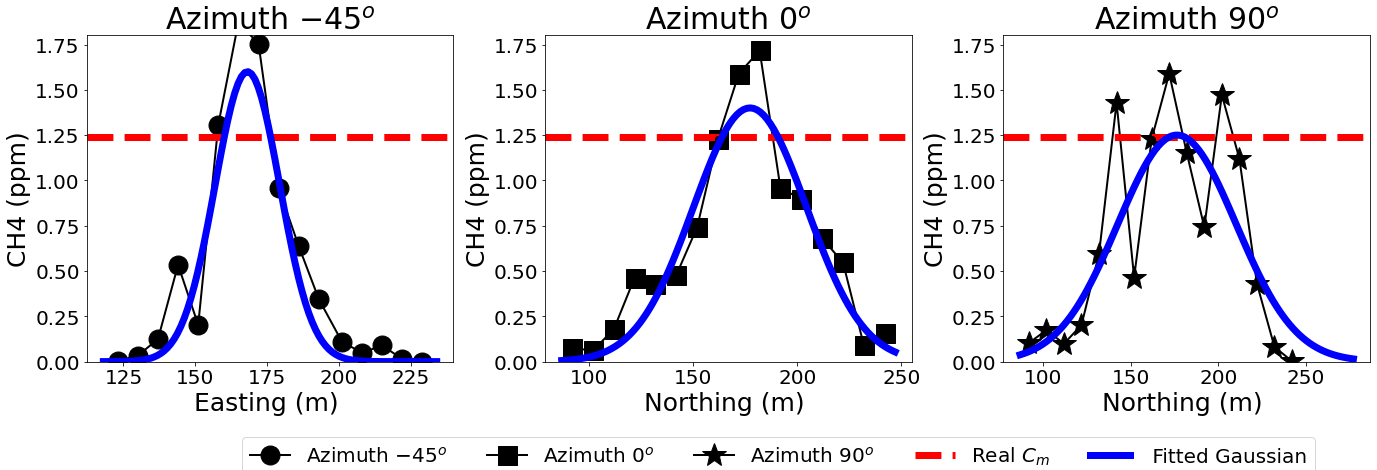

In [12]:
font = {'size'   : 20}
matplotlib.rc('font', **font)

fig, axs = plt.subplots(figsize=(23, 6), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.1, wspace=0.25)

#######################################################################################  
ax1=plt.subplot(1,3,1)
plt.plot(xrot_45_p,ic_45_p,'k-o',linewidth='2',markersize=19,label='Azimuth '+r'$-45^{o}$')
plt.xlabel('Easting (m) ',fontsize='25')
plt.ylabel('CH4 (ppm)',fontsize='25') 
plt.axhline(fix, ls='--',linewidth=7,color='r')
xx=xrot_45_p; yy=ic_45_p;n=len(xx);mean = sum(xx)/n;sigma=sum(xx-mean)**2/n

# Fit the data using a Gaussian
g_init = models.Gaussian1D(amplitude=0.1, mean=mean, stddev=mean )
fit_g = fitting.LevMarLSQFitter()
g = fit_g(g_init, xx, yy)

# Plot the data with the best-fit model
plt.plot(xx, yy, 'ko')
xx1=np.linspace(min(xx)-5,max(xx)+5, num=100)
plt.plot(xx1, (g(xx1)/max(g(xx1)))*1.6,'b',linewidth=7)
Cm_45=1.6
plt.ylim((0, 1.8)) 
plt.title('Azimuth '+r'$-45^{o}$',fontsize='30')

#######################################################################################       
ax1=plt.subplot(1,3,2)
plt.plot(yrot_0_p,ic_0_p,'k-s',linewidth='2',markersize=19,label='Azimuth '+r'$0^{o}$')
plt.xlabel('Northing (m) ',fontsize='25')
plt.ylabel('CH4 (ppm)',fontsize='25') 
plt.axhline(fix, ls='--',linewidth=7,color='r')
xx=yrot_0_p; yy=ic_0_p;n=len(xx);mean = sum(xx)/n;sigma=sum(xx-mean)**2/n

# Fit the data using a Gaussian
g_init = models.Gaussian1D(amplitude=0.1, mean=mean, stddev=mean )
fit_g = fitting.LevMarLSQFitter()
g = fit_g(g_init, xx, yy)

# Plot the data with the best-fit model
plt.plot(xx, yy, 'ko')
xx1=np.linspace(min(xx)-5,max(xx)+5, num=100)
plt.plot(xx1, (g(xx1)/max(g(xx1)))*1.4,'b',linewidth=7)
Cm_0=1.4
plt.ylim((0, 1.8)) 
plt.title('Azimuth '+r'$0^{o}$',fontsize='30')

####################################################################################### 
ax1=plt.subplot(1,3,3)
plt.plot(xrot_90_p,ic_90_p,'k-*',linewidth='2.0',markersize=25,label='Azimuth '+r'$90^{o}$')
plt.xlabel('Northing (m) ',fontsize='25')
plt.ylabel('CH4 (ppm)',fontsize='25') 
plt.axhline(fix, ls='--',linewidth=7,color='r',label='Real '+r'$C_{m}$')
xx=xrot_90_p;yy=ic_90_p;n=len(xx); mean = sum(xx)/n;sigma=sum(xx-mean)**2/n

# Fit the data using a Gaussian
g_init = models.Gaussian1D(amplitude=0.1, mean=mean, stddev=mean)
fit_g = fitting.LevMarLSQFitter()
g = fit_g(g_init, xx, yy)

# Plot the data with the best-fit model
plt.plot(xx, yy, 'ko')
xx1=np.linspace(min(xx)-5,max(xx)+35, num=100)
plt.plot(xx1, (g(xx1)/max(g(xx1)))*1.25,'b',linewidth=7, label=' Fitted Gaussian')
Cm_90=1.25
plt.ylim((0, 1.8))   
text = fig.text(0.7,-0.1, " ")
fig.legend(loc=0,ncol=5,bbox_to_anchor=(0.8,0.099)) 
plt.title('Azimuth '+r'$90^{o}$',fontsize='30')
#fig.savefig('Profile_wind_direction.pdf', bbox_inches='tight',dpi=600)
plt.show()

Figure below shows the result of PSG estimation. Azimuth $90^{\circ}$ has the lowest error (1.42 \%) since maximum value of the fitted Gaussian is close to real peak concentration (Real $C_{m}=1.23$ ppm); azimuth $-45^{\circ}$ has the highest error (28.57 \%) due to remarkable difference with the real $C_{m}$. However, this is a naive estimation since the fitted Gaussian models are very uncertain due to noisy concentration values that are far from an ideal Gaussian model. One could fit randomly many (say 100) possible Gaussian models to concentration values (see Figure below) to assess uncertainty. However, this is not a reliable approach for quantification of uncertainty since the concentration profile fluctuates because of unstable weather condition

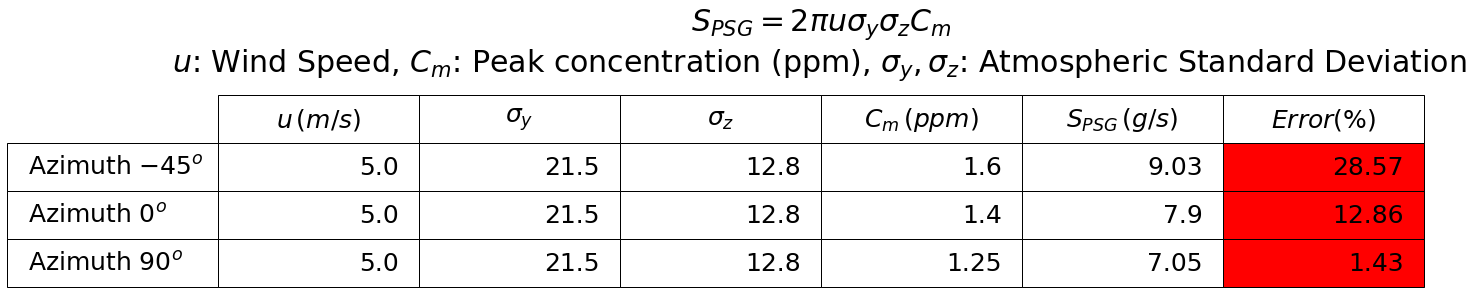

In [13]:
font = {'size'   : 25}
matplotlib.rc('font', **font)

columns = (r'$u \,(m/s)$', r'$\sigma_{y}$', r'$\sigma_{z}$', r'$C_{m}\,(ppm)$', r'$S_{PSG}\,(g/s)$', r'$Error (\%)$')
rows = ['Azimuth '+r'$-45^{o}$', 'Azimuth '+r'$0^{o}$', 'Azimuth '+r'$90^{o}$']

data_list=zeros((3,6))
a1=5; a2=5; a3=5
data_list[0,0]=round(a1,2) ; data_list[1,0]=round(a2,2); data_list[2,0]=round(a3,2)
data_list[:,1]=round(sigma_y_,1) ; data_list[:,2]=round(sigma_Z_,1)
data_list[0,3]=round(Cm_45,2) ; data_list[1,3]=round(Cm_0,2) ;data_list[2,3]=round(Cm_90,2) 
data_list[0,4]=np.round((2*np.pi*a1*sigma_y_*sigma_Z_*(16*Cm_45/24.45)*10**-3) ,2)
data_list[0,5]=np.round(((np.round((2*np.pi*a1*sigma_y_*sigma_Z_*(16*Cm_45/24.45)*10**-3) ,1)-7.)/7)*100,2)
data_list[1,4]=np.round((2*np.pi*a2*sigma_y_*sigma_Z_*(16*Cm_0/24.45)*10**-3),2)
data_list[1,5]=np.round(((np.round((2*np.pi*a2*sigma_y_*sigma_Z_*(16*Cm_0/24.45)*10**-3) ,1)-7.)/7)*100,2)
data_list[2,4]=np.round((2*np.pi*a3*sigma_y_*sigma_Z_*(16*Cm_90/24.45)*10**-3) ,2)
data_list[2,5]=np.round(((np.round((2*np.pi*a3*sigma_y_*sigma_Z_*(16*Cm_90/24.45)*10**-3) ,1)-7.)/7)*100,2)

ytable =plt.table(cellText=data_list,rowLabels=rows,colLabels=columns, loc="center",
          colWidths=[0.6 for x in columns])
plt.title(r"$S_{PSG}=2\pi u \sigma_{y}\sigma_{z}C_{m} \,\,\,\,\,\,\,\,\,\,\,\,$"+'\n'+
          r"$u$"+ ": Wind Speed, "+r"$ C_{m}$"+ ": Peak concentration (ppm), "+
         '$\sigma_{y},\sigma_{z}$'+ ": Atmospheric Standard Deviation ")
plt.axis("off")
ytable._cells[(1, 5)].set_facecolor("r");ytable._cells[(2, 5)].set_facecolor("r")
ytable._cells[(3, 5)].set_facecolor("r")
ytable.scale(1, 4)
plt.show()

###  Randomly fit 100 Gaussian models for the concentration profiles of azimuths $0^{\circ}$, $-45^{\circ}$ and $90^{\circ}$

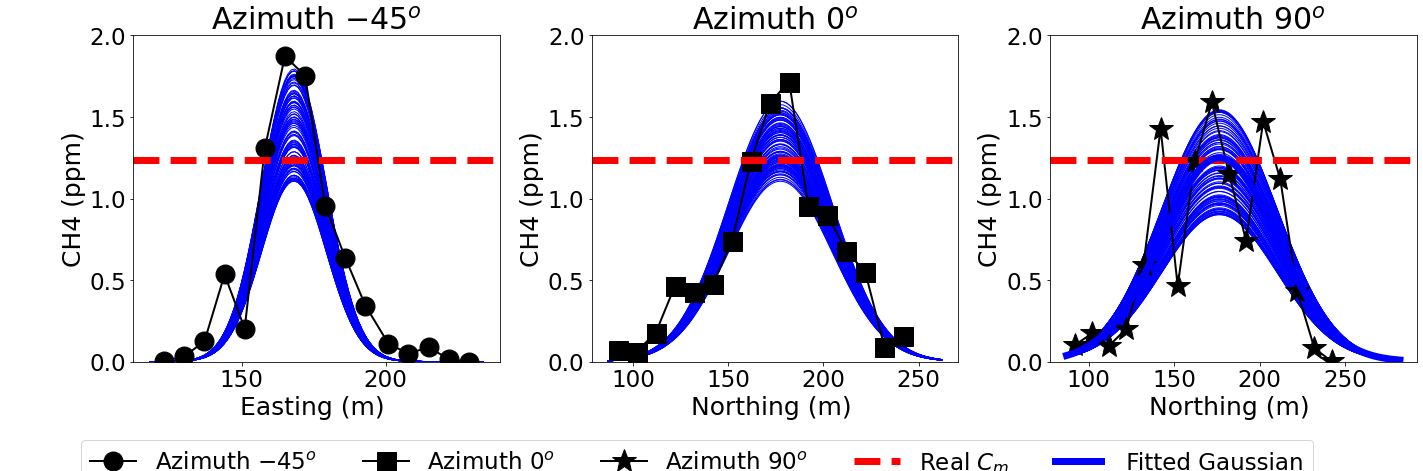

In [14]:
font = {'size'   : 23}
matplotlib.rc('font', **font)
fig, axs = plt.subplots(figsize=(23, 6), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.1, wspace=0.25)

ax1=plt.subplot(1,3,1)
xx=xrot_45_p;yy=ic_45_p; n=len(xx);mean = sum(xx)/n;sigma=sum(xx-mean)**2/n

# Fit the data using a Gaussian
g_init = models.Gaussian1D(amplitude=0.1, mean=mean, stddev=mean )
fit_g = fitting.LevMarLSQFitter()
g = fit_g(g_init, xx, yy)

xx1=np.linspace(min(xx)-5,max(xx)+5, num=100)
s = np.random.uniform(1.1,1.8,100)
for ii in range(100):
    plt.plot(xx1, (g(xx1)/max(g(xx1)))*s[ii],'b',linewidth=1)

plt.plot(xrot_45_p,ic_45_p,'k-o',linewidth='2',markersize=19,label='Azimuth '+r'$-45^{o}$')
plt.xlabel('Easting (m) ',fontsize='25')
plt.ylabel('CH4 (ppm)',fontsize='25') 
plt.axhline(fix, ls='--',linewidth=7,color='r')
plt.ylim((0, 2))
plt.title('Azimuth '+r'$-45^{o}$',fontsize='30')
#######################################################################################       
ax1=plt.subplot(1,3,2)
xx=yrot_0_p;yy=ic_0_p;n=len(xx);mean = sum(xx)/n;sigma=sum(xx-mean)**2/n

# Fit the data using a Gaussian
g_init = models.Gaussian1D(amplitude=0.1, mean=mean, stddev=mean )
fit_g = fitting.LevMarLSQFitter()
g = fit_g(g_init, xx, yy)

# Plot the data with the best-fit model
plt.plot(xx, yy, 'ko')
xx1=np.linspace(min(xx)-5,max(xx)+20, num=100)
s = np.random.uniform(1.1,1.6,100)
for ii in range(100):
    plt.plot(xx1, (g(xx1)/max(g(xx1)))*s[ii],'b',linewidth=1)
plt.plot(yrot_0_p,ic_0_p,'k-s',linewidth='2',markersize=19,label='Azimuth '+r'$0^{o}$')
plt.xlabel('Northing (m) ',fontsize='25')
plt.ylabel('CH4 (ppm)',fontsize='25') 
plt.axhline(fix, ls='--',linewidth=7,color='r')
plt.ylim((0, 2))
plt.title('Azimuth '+r'$0^{o}$',fontsize='30')
####################################################################################### 
ax1=plt.subplot(1,3,3)
xx=xrot_90_p;yy=ic_90_p;n=len(xx);mean = sum(xx)/n;sigma=sum(xx-mean)**2/n

# Fit the data using a Gaussian
g_init = models.Gaussian1D(amplitude=0.1, mean=mean, stddev=mean)
fit_g = fitting.LevMarLSQFitter()
g = fit_g(g_init, xx, yy)
xx1=np.linspace(min(xx)-5,max(xx)+40, num=100)
s = np.random.uniform(0.9,1.55,100)
for ii in range(100):
    plt.plot(xx1, (g(xx1)/max(g(xx1)))*s[ii],'b',linewidth=1)
plt.plot(xrot_90_p,ic_90_p,'k-*',linewidth='2.0',markersize=25,label='Azimuth '+r'$90^{o}$')
plt.xlabel('Northing (m) ',fontsize='25')
plt.ylabel('CH4 (ppm)',fontsize='25') 
plt.axhline(fix, ls='--',linewidth=7,color='r',label='Real '+r'$C_{m}$')
plt.plot(xx1, (g(xx1)/max(g(xx1)))*1.25,'b',linewidth=7, label=' Fitted Gaussian')
plt.ylim((0, 2))  
text = fig.text(0.7,-0.1, " ")
fig.legend(loc=0,ncol=5,bbox_to_anchor=(0.8,0.099)) 
plt.title('Azimuth '+r'$90^{o}$',fontsize='30')
#fig.savefig('Profile_wind_direction_all Gaussian.pdf', bbox_inches='tight',dpi=600)
plt.show()

### Six Simulated Realization Six more Field Measurements 

6 other realizations of the simulated model is generated as if they are sampled for different times. Figure below shows concentration profiles (azimuths $0^{\circ}$, $-45^{\circ}$ and $90^{\circ}$) for 6 realizations. Variations between realizations can depict uncertainty in the concentration measurements. Reliable approach to capture full uncertainty is to repeat mobile measurement for a plume many times. Each measurement has one estimation of emission rate; by aggregating all estimations, distribution of uncertainty in emission rate is achieved. However, this approach may not be practical since exhaustive mobile measurement is costly and labour-intensive for a large area. 

In [15]:
# Reading simulated data
varkk_sim=[]
for isim in range(6):
    txt='./synthetic plume/Random_SGS_'+str(isim+2) 
    with open(txt) as f:
        vt1=[]
        for i in range(3):
            next(f)    
        for line in f:
            p = line.split()      
            vt1.append(float(p[0]))         
    varkk_tmp=[]
    for j in range(ny):
        for i in range(nx):     
            index1=i+1 + (j-1+1)*nx 
            varkk_tmp.append(vt1[index1-1])
    varkk_sim.append(varkk_tmp) 
               
#  Rotate coordinate system
Ang=135; xa=[];ya=[] 
Angle=Ang *(math.pi/180)
for j in range(ny):
    for i in range(nx):
        tmp1=xmin+(i)*xsiz
        tmp2=ymin+(j)*ysiz
        X=(tmp2-yshift)*sin(Angle)+(tmp1-xshift)*cos(Angle)
        xa.append(round(X,0))
        Y=(tmp2-yshift)*cos(Angle)-(tmp1-xshift)*sin(Angle)
        ya.append(round(Y,0))      

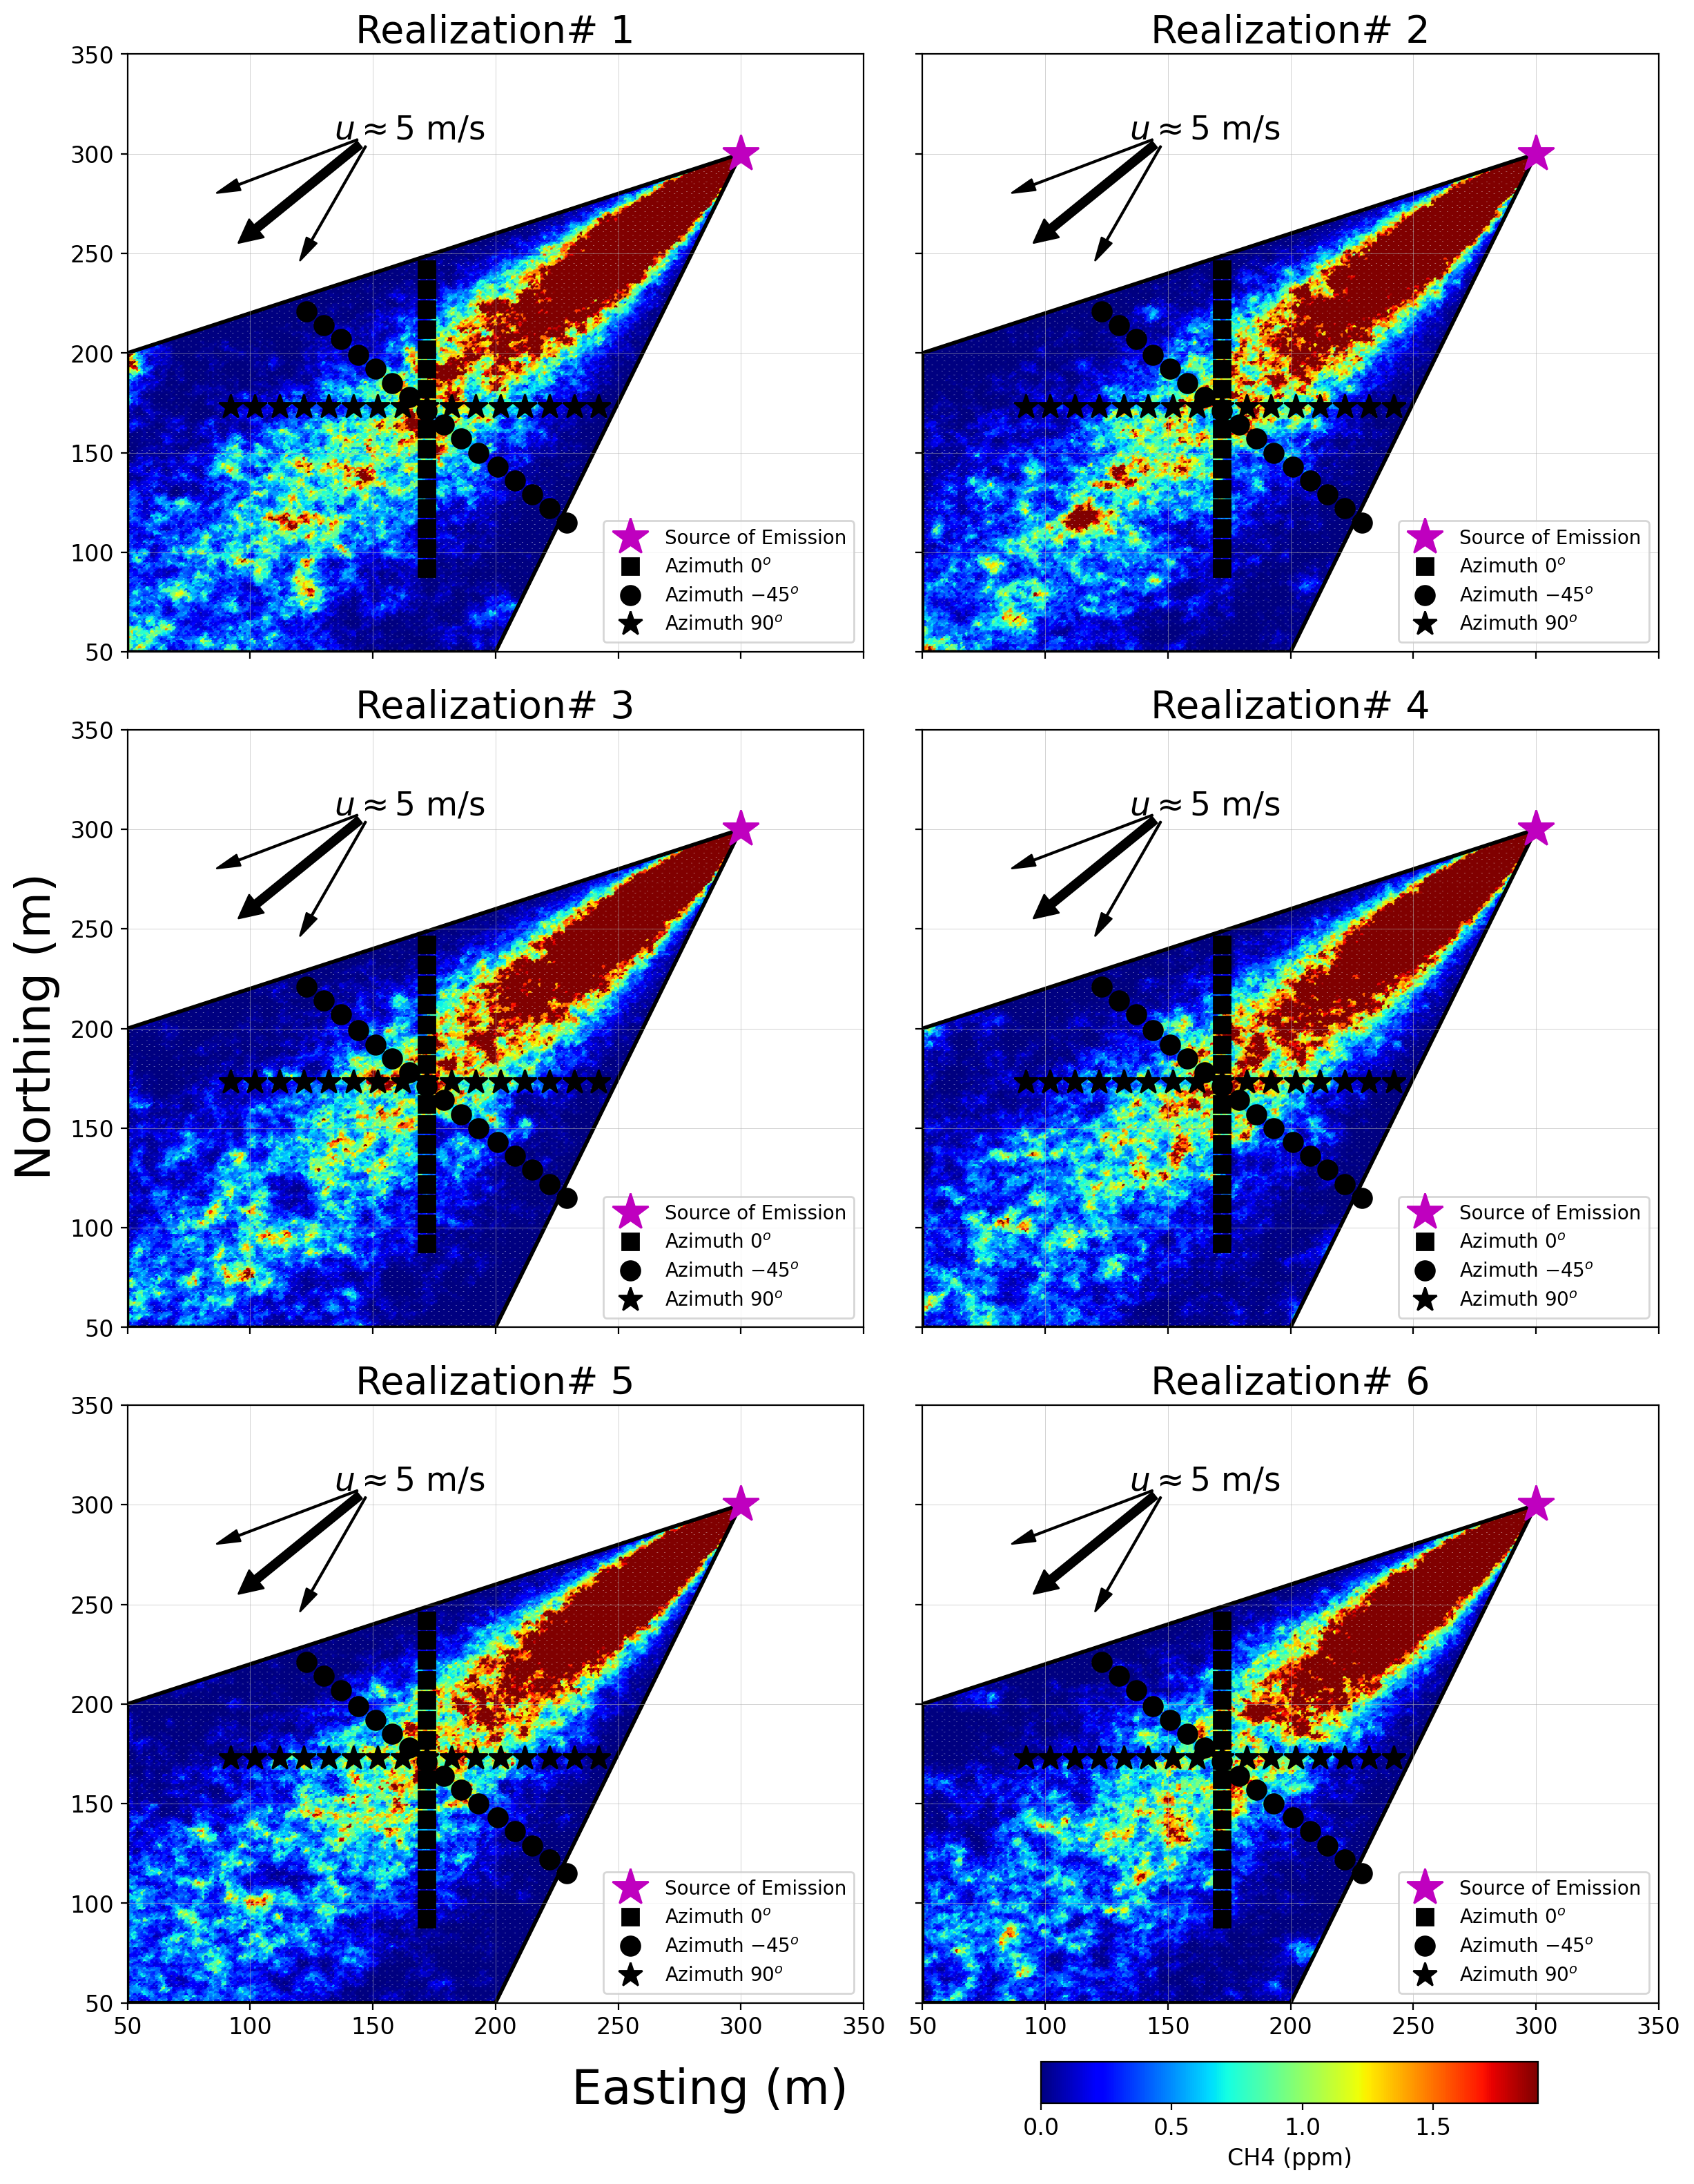

In [16]:
font = {'size'   :12}
matplotlib.rc('font', **font)
fig=plt.figure(figsize=(12, 15), dpi= 200, facecolor='w', edgecolor='k')
vmin=min(result);vmax=max(result) 
xrot_0=[];yrot_0=[];ic_0=[]
xrot_45=[];yrot_45=[];ic_45=[]
xrot_90=[];yrot_90=[];ic_90=[]

for isim in range(6):
    if(isim<6):
        ax1=plt.subplot(3,2,isim+1)
        x_o=300;y_o=300
        plt.title("Realization# "+str(isim+1),fontsize='20')
        plt.xlim((50, 350))
        plt.ylim((50, 350))  
        plt.grid(linewidth=0.2)
        plt.plot(x_o,y_o,'m*',markersize=20, label='Source of Emission')
        Final=varkk_sim[isim]
        filt=0.0
        a=np.array([int(x+x_o) for x in xa])
        b=np.array([int(x+y_o) for x in ya])
        path=(50,200),(300,300),(200,50),(50,50),(50,200)
        path1 = np.asarray(path)
        path2 = Path(path1)
        patch = PathPatch(path2, facecolor='none',linewidth=2)
        XX=300-180*cos(45 *(math.pi/180))
        YY=300-180*sin(45 *(math.pi/180))  
        tmp1=[XX for j in range(16)]
        tmp2=[YY+j for j in range(-80,80,10)]
        tmp3=[]
        for i in range(len(tmp1)):
            value=tmp1[i],tmp2[i]
            array=[(a[j],b[j]) for j in range(len(a))]
            idx=find_nearest(array, value)
            tmp3.append(Final[idx])             
        xrot_0.append([int(tmp1[x]) for x in range(len(tmp1)) if tmp3[x]>filt])  
        yrot_0.append([int(tmp2[x]) for x in range(len(tmp2)) if tmp3[x]>filt])
        ic_0.append([tmp3[x] for x in range(len(tmp3)) if tmp3[x]>filt])
        plt.plot(xrot_0[isim],yrot_0[isim],'ks',markersize=8.3,linewidth=3,label='Azimuth '+r'$0^{o}$')
        tmp1,tmp2=rotate(XX,YY,xrot_0[isim],yrot_0[isim],-45)
        tmp3=[]
        for i in range(len(tmp1)):
            value=tmp1[i],tmp2[i]
            array=[(a[j],b[j]) for j in range(len(a))]
            idx=find_nearest(array, value)
            tmp3.append(Final[idx])              
        xrot_45.append([int(tmp1[x]) for x in range(len(tmp1)) if tmp3[x]>filt])  
        yrot_45.append([int(tmp2[x]) for x in range(len(tmp2)) if tmp3[x]>filt])
        ic_45.append([tmp3[x] for x in range(len(tmp3)) if tmp3[x]>filt])    
        plt.plot(xrot_45[isim],yrot_45[isim],'ko',markersize=10,linewidth=3,label='Azimuth '+r'$-45^{o}$')
        tmp1,tmp2=rotate(XX,YY,xrot_0[isim],yrot_0[isim],90)
        tmp3=[]
        for i in range(len(tmp1)):
            value=tmp1[i],tmp2[i]
            array=[(a[j],b[j]) for j in range(len(a))]
            idx=find_nearest(array, value)
            tmp3.append(Final[idx])              
        xrot_90.append([int(tmp1[x]) for x in range(len(tmp1)) if tmp3[x]>filt])  
        yrot_90.append([int(tmp2[x]) for x in range(len(tmp2)) if tmp3[x]>filt])
        ic_90.append([tmp3[x] for x in range(len(tmp3)) if tmp3[x]>filt])      
        plt.plot(xrot_90[isim],yrot_90[isim],'k*',markersize=13,linewidth=3,label='Azimuth '+r'$90^{o}$')
        xstart=150;ystart=310;length=85
        x_,y_=Arrow(xstart,ystart,length,Ang-90+180)
        ax1.text(xstart+15, ystart+2, r'$u\approx$'+'5 m/s', size=17, ha='center', va='center')   
        ax1.annotate('',xy=(x_,y_), xytext=(xstart, ystart),
                     arrowprops=dict(facecolor='black',shrink=0.09),)
        xstart=150;ystart=310;length=77
        x_,y_=Arrow(xstart,ystart,length,Ang-90+180+20)
        ax1.text(xstart+15, ystart+2,'', size=13, ha='center', va='center')   
        ax1.annotate('',xy=(x_,y_), xytext=(xstart, ystart),
                     arrowprops=dict(width=0.5,headwidth=6,facecolor='black',shrink=0.09),)
        x_,y_=Arrow(xstart,ystart,length,Ang-90+180-20)
        ax1.text(xstart+15, ystart+2, '', size=13, ha='center', va='center')   
        ax1.annotate('',xy=(x_,y_), xytext=(xstart, ystart),
                     arrowprops=dict(width=0.5,headwidth=6,facecolor='black',shrink=0.09),)
        if(isim==0 or isim==2 ):
            ax1.set_xticklabels([])
        elif(isim==5 ):
            ax1.set_yticklabels([])
        elif(isim==4 ):  
            pass  
        else:
            ax1.set_xticklabels([])
            ax1.set_yticklabels([])        
        plt.legend(loc=4,fontsize= 'small') 
        a1=[a[x] for x in range(len(a)) if (path2.contains_points([(a[x],b[x])]))[0]]        
        b1=[b[x] for x in range(len(b)) if (path2.contains_points([(a[x],b[x])]))[0]]        
        c1=[Final[x] for x in range(len(b)) if (path2.contains_points([(a[x],b[x])]))[0]]
        plt.scatter(a1,b1,c=c1,s=1,cmap='jet',vmin=vmin,vmax=1.9)  
        plt.gca().add_patch(patch)         
        if(isim==5):           
            cbaxes = fig.add_axes([0.60, -0.02, 0.30, 0.02])  
            plt.colorbar(orientation='horizontal',shrink=0.8,cax = cbaxes,label='CH4 (ppm)')
fig.tight_layout(pad=1) 
plt.subplots_adjust(wspace=0.08)
plt.subplots_adjust(hspace=0.13)
fig.text(0.4 ,-0.02, 'Easting (m)', ha='center',fontsize='25')
fig.text(-0.02, 0.5, 'Northing (m)', va='center', rotation='vertical',fontsize='25')
plt.show()
#fig.savefig('Nonconstant_6 real_wind_direction.png', bbox_inches='tight',dpi=200)

### Concentration Profiles for Azimuths $0^{\circ}$, $-45^{\circ}$ and $90^{\circ}$ for 6 Realizations 

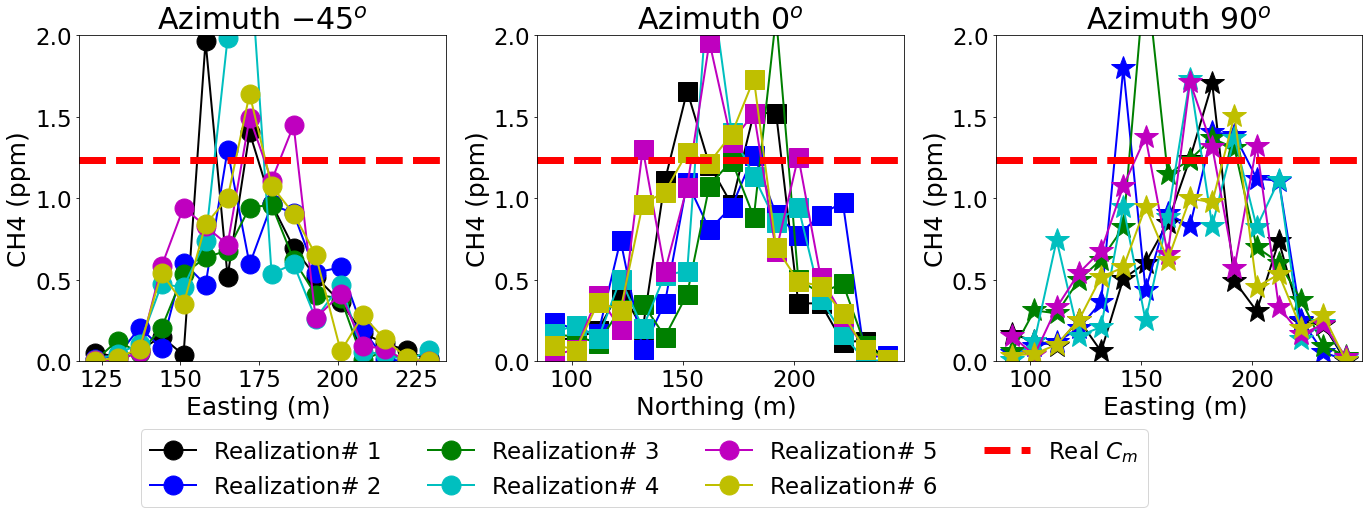

In [63]:
jet= plt.get_cmap('jet')
colors = iter(jet(np.linspace(0,6,20)))
font = {'size'   : 23}
matplotlib.rc('font', **font)
fig, axs = plt.subplots(figsize=(23, 6), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.1, wspace=0.25)
cod=["" for x in range(6)]
cod[0]='k';cod[1]='b';cod[2]='g';cod[3]='c';cod[4]='m';cod[5]='y'
lab=["" for x in range(6)]
lab[0]='Realization# 1';lab[1]='Realization# 2';lab[2]='Realization# 3';lab[3]='Realization# 4';
lab[4]='Realization# 5'; lab[5]='Realization# 6'
for isim in range(6):
    ax1=plt.subplot(1,3,1)
    plt.plot(xrot_45[isim],ic_45[isim],'-o',color=cod[isim],linewidth='2',
             markersize=19,label=lab[isim])
    plt.xlabel('Easting (m) ',fontsize='25')
    plt.ylabel('CH4 (ppm)',fontsize='25') 
    labe=None
    if (isim==5):labe='Real '+r'$C_{m}$'
    plt.axhline(fix, ls='--',linewidth=7,color='r',label=labe)
    plt.ylim((0, 2))  
    plt.title('Azimuth '+r'$-45^{o}$',fontsize='30')
text = fig.text(0.8,-0.2, " ")    
fig.legend(loc=4, ncol=4,bbox_to_anchor=(0.7,-0.01))      
    ####################################################################################### 
for isim in range(6):    
    ax1=plt.subplot(1,3,2)
    if (isim==5):label='Azimuth '+r'$0^{o}$'
    plt.plot(yrot_0[isim],ic_0[isim],'-s',color=cod[isim],linewidth='2'
             ,markersize=19)
    plt.xlabel('Northing (m) ',fontsize='25')
    plt.ylabel('CH4 (ppm)',fontsize='25') 
    plt.axhline(fix, ls='--',linewidth=7,color='r')
    xx=yrot_0[isim]
    yy=ic_0[isim]
    plt.ylim((0, 2))  
    plt.title('Azimuth '+r'$0^{o}$',fontsize='30')
    ####################################################################################### 
for isim in range(6):    
    ax1=plt.subplot(1,3,3)
    plt.plot(xrot_90[isim],ic_90[isim],'-*',color=cod[isim],linewidth='2.0',
             markersize=25)
    plt.xlabel('Easting (m) ',fontsize='25')
    plt.ylabel('CH4 (ppm)',fontsize='25') 
    plt.axhline(fix, ls='--',linewidth=7,color='r')
    plt.ylim((0, 2))  
    plt.title('Azimuth '+r'$90^{o}$',fontsize='30')

#fig.savefig('Profile_All_wind_direction.pdf',dpi=600)
plt.show()

# Quantify Uncertainty in Average Wind Speed

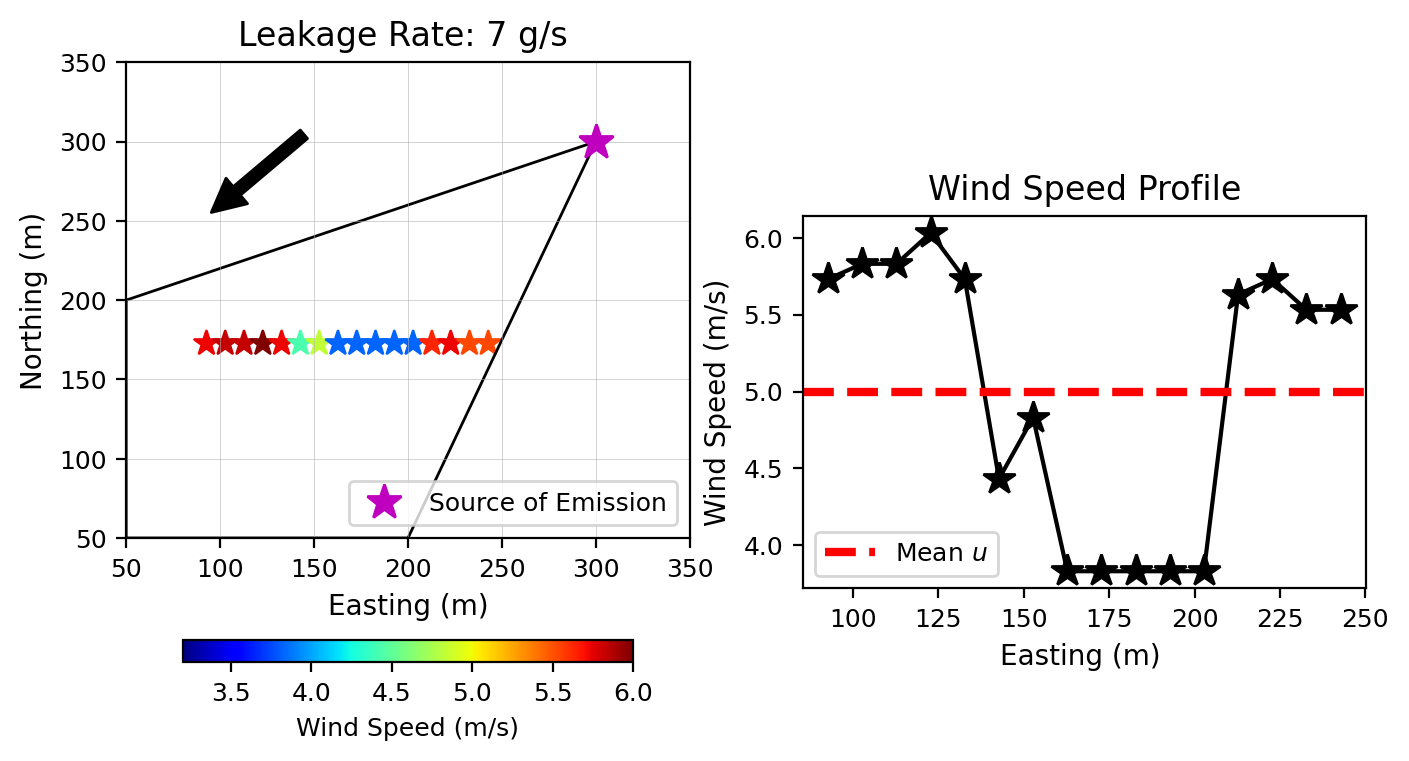

In [15]:
wind_speed=np.zeros(16)
wind_speed[0]= 5.875; wind_speed[1]= 5.974; wind_speed[2]= 5.974; wind_speed[3]= 6.175
wind_speed[4]= 5.875; wind_speed[5]= 4.575; wind_speed[6]= 4.974; wind_speed[7]= 3.974
wind_speed[8]= 3.974; wind_speed[9]= 3.974; wind_speed[10]= 3.974; wind_speed[11]= 3.974
wind_speed[12]= 5.774; wind_speed[13]= 5.875; wind_speed[14]= 5.675; wind_speed[15]= 5.675
#
wind_speed=[i-np.mean(wind_speed)+5 for i in wind_speed]
 
fontP = FontProperties()
fontP.set_size('small')
font = {'size'   : 9}
matplotlib.rc('font', **font)
fig=plt.figure(figsize=(8, 4.5), dpi= 200, facecolor='w', edgecolor='k')

vmin=min(result)
vmax=max(result) 

###############################################################################################
ax1=plt.subplot(1,2,1)
x_o=300;y_o=300
plt.title("Leakage Rate: "+str(Q)+" g/s ",
          fontsize='12')
plt.xlim((50, 350))   
plt.ylim((50, 350))  
plt.grid(linewidth=0.2)
plt.plot(x_o,y_o,'m*',markersize=13, label='Source of Emission')
filt=0.009
a=np.array([int(x+x_o) for x in xa])
b=np.array([int(x+y_o) for x in ya])
path=(50,200),(300,300),(200,50),(50,50),(50,200)
path1 = np.asarray(path)
path2 = Path(path1)
patch = PathPatch(path2, facecolor='none',linewidth=1)
plt.gca().add_patch(patch)
XX=300-180*cos(45 *(math.pi/180))
YY=300-180*sin(45 *(math.pi/180))
xrot_0_p=[XX for j in range(16)]
yrot_0_p=[YY+j for j in range(-80,80,10)]
xrot_90_p,yrot_90_p=rotate(XX,YY,xrot_0_p,yrot_0_p,90)
plt.scatter(xrot_90_p,yrot_90_p,c=wind_speed,marker='*',s=80,cmap='jet',vmin=3.2,vmax=6)  
plt.colorbar(orientation='horizontal',shrink=0.8,label='Wind Speed (m/s)')
xstart=150;ystart=310;length=85
x_,y_=Arrow(xstart,ystart,length,Ang-90+180)
ax1.annotate('',xy=(x_,y_), xytext=(xstart, ystart),
             arrowprops=dict(facecolor='black',shrink=0.09),)
plt.xlabel('Easting (m)',fontsize='10')
plt.ylabel('Northing (m)',fontsize='10')
plt.legend(loc=4)

###############################################################################################
ax1=plt.subplot(1,2,2)
plt.plot(xrot_90_p,wind_speed,'k-*',linewidth='1.5',markersize=12)
plt.xlabel('Easting (m) ',fontsize='10')
plt.ylabel('Wind Speed (m/s)',fontsize='10') 
plt.axhline(5, ls='--',linewidth=3,color='r',label='Mean '+r'$u$')
plt.title('Wind Speed Profile',fontsize='12')
plt.legend(loc=3)  
plt.gca().set_aspect('45')
plt.show()
WS_R=np.random.normal(np.mean(wind_speed),sqrt(np.var(wind_speed)),1000)
#fig.savefig('Nonconstant_ wind_Speed.pdf', bbox_inches='tight',dpi=600)


## Variogram (Spatial Correlation) of Wind Speed Profile 

In [16]:
#Normal Score Transformation
columns=['x_','y_','ws']
ws_pd=pd.DataFrame({columns[0]:np.array(xrot_90_p),columns[1]:np.array(yrot_90_p),columns[2]:
                      np.array(wind_speed)},columns=['x_','y_','ws'])
ns, vr, wt_ns=geostats.nscore(ws_pd, 'ws', wcol=None, ismooth=False, dfsmooth=None, smcol=0, smwcol=0)
ws_pd['NS_ws']=ns

#Experimental Variogram
tmin=-100;tmax=10000;xlag=10;xltol=5;nlag=10;azm=0;atol=90;bandwh=1000;isill=1
Lag1, Var1, npp_az0=geostats.gamv(ws_pd,'x_', 'y_','NS_ws',tmin,tmax,xlag,xltol,nlag,azm,atol,bandwh,isill)

# Fitted variogram Model Parameters
nlag=100; xlag=0.5
vario={'nst':1,'nug':0.0, 'cc1':1,'it1':1,'azi1':0,'hmaj1':46,'hmin1':46}
index,Lag1_fit,Var1_fit,cov,ro=geostats.vmodel(nlag, xlag, azm, vario)
clear_output()

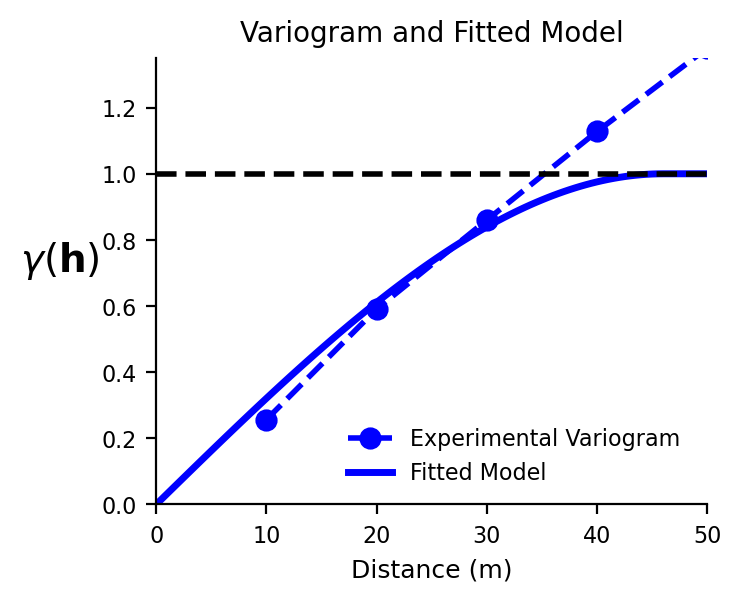

In [17]:
font = {'size'   : 8}
matplotlib.rc('font', **font)
fig, axs = plt.subplots(figsize=(8,6), dpi= 200, facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .05, wspace=0.25) 
#   
#Label and Title of Variogram Plot
label1='Experimental Variogram ' ;symbol1='--ob';label1_fit='Fitted Model ';symbol1_fit='-b'
xlabl='Distance (m)'; xlim=[0,50]; vlim=[0,1.35]; sill=1;loc=4

ax1=plt.subplot(1,2,1) 
#Plot Variograms 
Lag1=np.delete(Lag1, np.where(Var1==0))
Var1=np.delete(Var1, np.where(Var1==0))
plt.plot(Lag1, Var1,symbol1,linewidth=2,markersize=7,label=label1)          
plt.plot(Lag1_fit, Var1_fit,symbol1_fit,linewidth=2.5,label=label1_fit) 
plt.legend(fontsize=8,loc=loc,frameon=False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().set_aspect('30')
plt.axhline(y=sill,linewidth=2,color='k',linestyle='--')
title='Variogram and Fitted Model'
plt.title(title,fontsize=10)  
plt.xlabel(xlabl,fontsize=9)
ylabl='$\gamma (\mathbf{h}) $'
plt.ylabel(ylabl,rotation=0,fontsize=14,labelpad=15)
plt.xlim(float(xlim[0]),float(xlim[1]))
plt.ylim(float(vlim[0]),float(vlim[1])) 
plt.show()

## Spatial Bootstrap 

In [38]:
# First calculate bootstrap without considering the spatial correlation
x=ws_pd['x_'].values; y=ws_pd['y_'].values; var=ws_pd['ws'].values; seed=4970; nsim=100
vario={'nst':1,'nug':0.0, 'cc1':1,'it1':1,'azi1':0,'hmaj1':0.01,'hmin1':0.01}
BS_0, BS_m_0=Spatial_Bootstrap(x, y, WS_R, vario, seed, nsim,outfl=False)
clear_output()

In [39]:
# Calculate spatial bootstrap
vario={'nst':1,'nug':0.0, 'cc1':1,'it1':1,'azi1':0,'hmaj1':46,'hmin1':46}
seed=4970
BS_46, BS_m_46=Spatial_Bootstrap(x, y, WS_R, vario, seed, nsim,outfl=False)

 Effective number of data=  4.398099490223651
 Mean of mean= 5.0362 , Variance of the mean =  0.1799


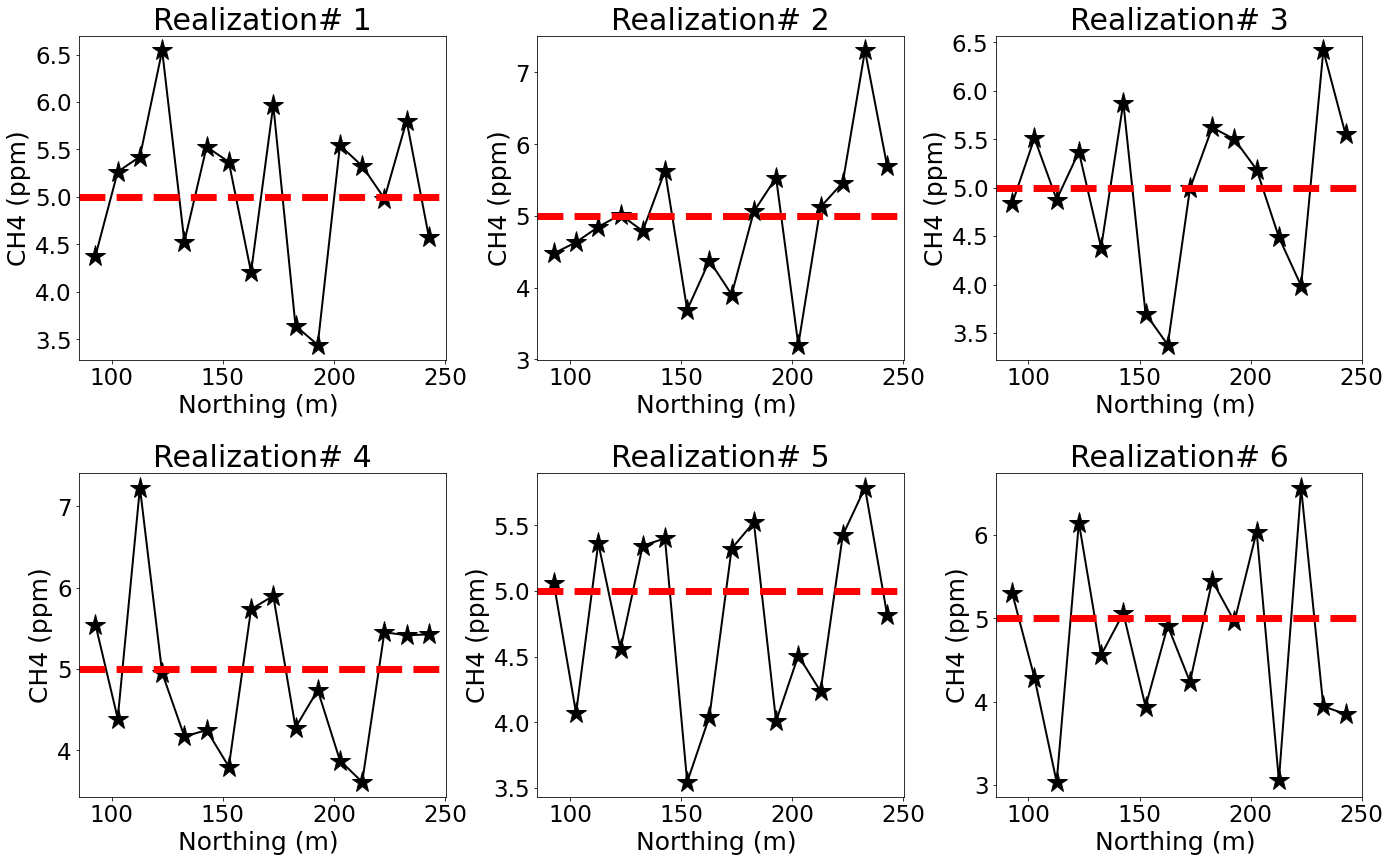

In [40]:
# Plot 6 ralizations of bootstrap without considering the spatial correlation 
jet= plt.get_cmap('gray')
colors = iter(jet(np.linspace(0,100,180*3*nsim)))

font = {'size'   : 23}
matplotlib.rc('font', **font)

fig, axs = plt.subplots(figsize=(23, 14), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.35, wspace=0.25)
#  
for isim in range(6):
    ax1=plt.subplot(2,3,isim+1)
    plt.plot(xrot_90_p,BS_0[isim],'-*',markerfacecolor="k",color=next(colors),linewidth='2.0',markersize=22,label='Plume')
    plt.xlabel('Northing (m) ',fontsize='25')
    plt.ylabel('CH4 (ppm)',fontsize='25') 
    plt.axhline(5, ls='--',linewidth=7,color='r')
    plt.title('Realization# '+str(isim+1),fontsize='30')
#fig.savefig('Profile_All_wind_speed.pdf',dpi=600)
plt.show()

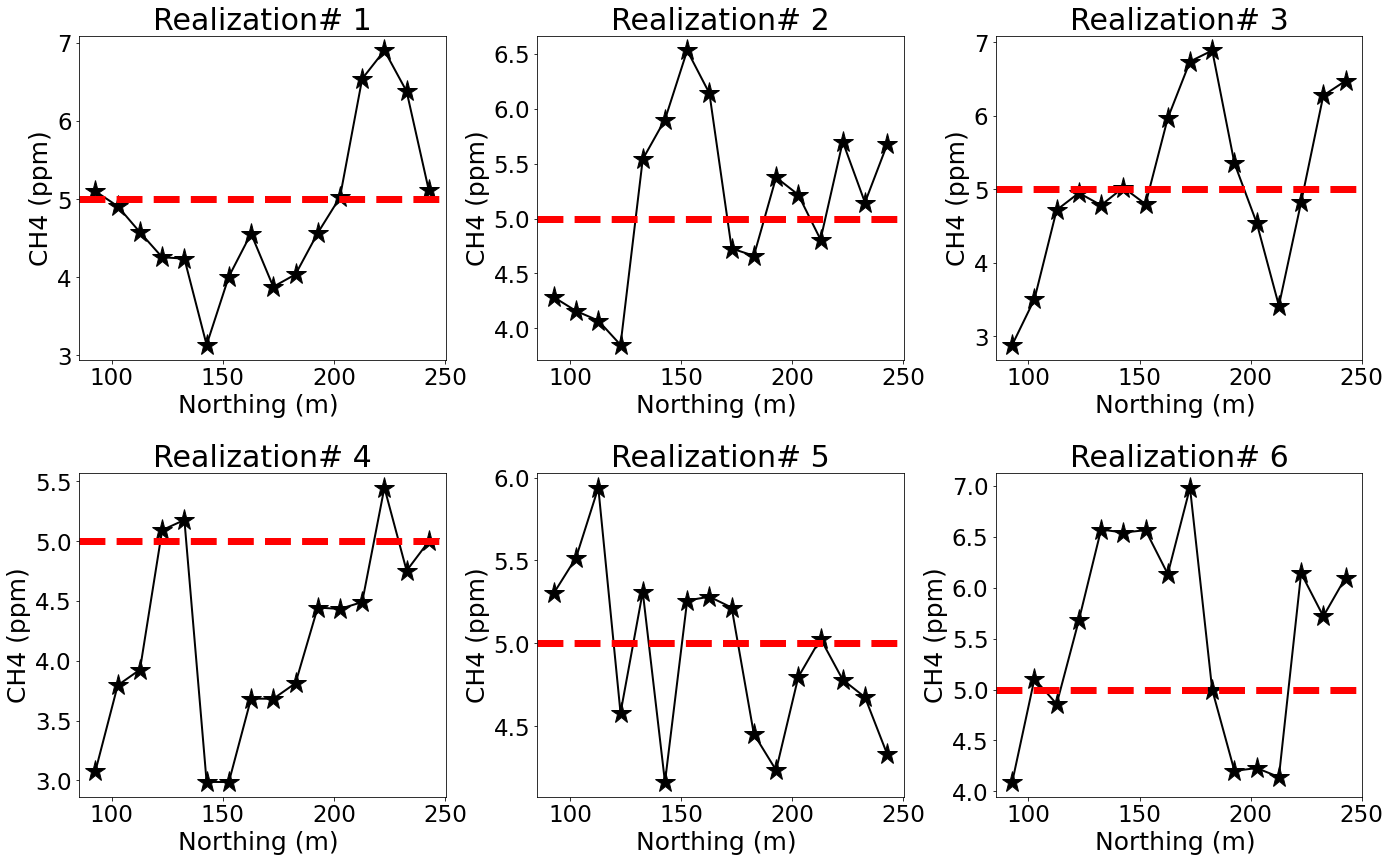

In [41]:
# Plot 6 ralizations of spatial bootstrap considering the spatial correlation

jet= plt.get_cmap('gray')
colors = iter(jet(np.linspace(0,100,180*3*nsim)))
font = {'size'   : 23}
matplotlib.rc('font', **font)

fig, axs = plt.subplots(figsize=(23, 14), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.35, wspace=0.25)

for isim in range(6):
    ax1=plt.subplot(2,3,isim+1)
    plt.plot(xrot_90_p,BS_46[isim],'-*',markerfacecolor="k",color=next(colors),linewidth='2.0',markersize=22,label='Plume')
    plt.xlabel('Northing (m) ',fontsize='25')
    plt.ylabel('CH4 (ppm)',fontsize='25') 
    plt.axhline(5, ls='--',linewidth=7,color='r')
    plt.title('Realization# '+str(isim+1),fontsize='30')
#fig.savefig('Profile_All_wind_speed_corr.pdf',dpi=600)
plt.show()

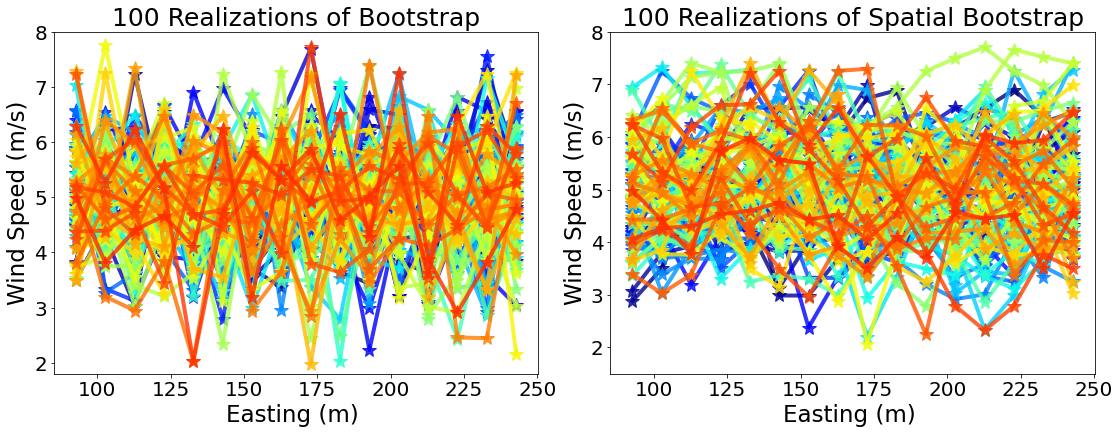

In [42]:
jet= plt.get_cmap('jet')
colors = iter(jet(np.linspace(0,100,115*nsim)))
font = {'size'   : 20}
matplotlib.rc('font', **font)

fig, axs = plt.subplots(figsize=(23, 6), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.1, wspace=0.25)
alpha_=[1-i/nsim  for i in range(nsim)]
ax1=plt.subplot(1,3,1)
for isim in range(nsim):
    plt.plot(xrot_90_p,BS_0[isim],'-*',color=next(colors),linewidth='4',
             markersize=14,alpha=0.8)
plt.ylim((1.8, 8))   
plt.xlabel('Easting (m) ',fontsize='23')
plt.ylabel('Wind Speed (m/s)',fontsize='23') 
plt.title('100 Realizations of Bootstrap',fontsize='25') 
jet= plt.get_cmap('jet')
colors = iter(jet(np.linspace(0,100,115*nsim)))
ax1=plt.subplot(1,3,2)
for isim in range(nsim):
    plt.plot(xrot_90_p,BS_46[isim],'-*',color=next(colors),linewidth='4',
             markersize=14,alpha=0.8)
plt.ylim((1.5, 8)) 
plt.xlabel('Easting (m) ',fontsize='23')
plt.ylabel('Wind Speed (m/s)',fontsize='23') 
plt.title('100 Realizations of Spatial Bootstrap',fontsize='25') 
fig.tight_layout(pad=0.3) 
#fig.savefig('Profile_All_wind_speed_corr.pdf', bbox_inches='tight',dpi=200)
plt.show()

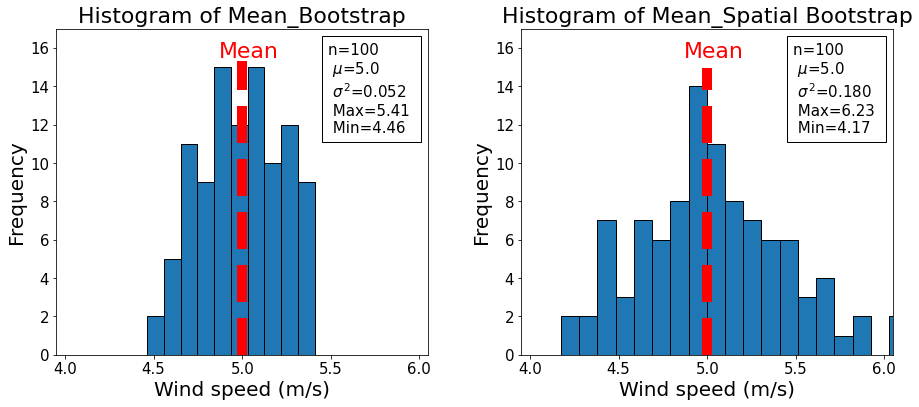

In [70]:
jet= plt.get_cmap('jet')
colors = iter(jet(np.linspace(0,100,115*nsim)))

font = {'size'   : 15}
matplotlib.rc('font', **font)

fig, axs = plt.subplots(figsize=(15, 6), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.1, wspace=0.25)
#
alpha_=[1-i/nsim  for i in range(nsim)]
ax1=plt.subplot(1,2,1)
val=np.array(BS_m_0)
plt.hist(val, bins=10,ec='black')      
n=len(val)
Mean=np.mean(val)
SD=np.var(val) 
Max=np.amax(val)
Min=np.amin(val)
txt='n=%.0f \n $\mu$=%.1f \n $\sigma^{2}$=%.3f \n Max=%.2f \n Min=%.2f'
anchored_text = AnchoredText(txt %(n,Mean,SD,Max,Min), loc=1)
ax1.add_artist(anchored_text)
plt.title('Histogram of Mean_Bootstrap',fontsize='22')    
plt.xlabel('Wind speed (m/s)',fontsize='20')            
plt.ylabel('Frequency',fontsize='20')    
plt.axvline(5,ymin=0, ymax=0.90, ls='--',linewidth=10.0,color='r')
plt.xlim((3.95, 6.05)) 
plt.ylim((0, 17))  
plt.annotate(s='Mean',xy=(4.87,15.5),color='r',fontsize='22')
ax1=plt.subplot(1,2,2)
val=np.array(BS_m_46)
plt.hist(val, bins=20,ec='black')      
n=len(val)
Mean=np.mean(val)
SD=np.var(val) 
Max=np.amax(val)
Min=np.amin(val)
txt='n=%.0f \n $\mu$=%.1f \n $\sigma^{2}$=%.3f \n Max=%.2f \n Min=%.2f'
anchored_text = AnchoredText(txt %(n,Mean,SD,Max,Min), loc=1)
ax1.add_artist(anchored_text)
plt.title('Histogram of Mean_Spatial Bootstrap',fontsize='22')    
plt.xlabel('Wind speed (m/s)',fontsize='20')            
plt.ylabel('Frequency',fontsize='20')    
plt.axvline(5,ymin=0, ymax=0.88, ls='--',linewidth=10.0,color='r')
plt.xlim((3.95, 6.05)) 
plt.ylim((0, 17)) 
plt.annotate(s='Mean',xy=(4.87,15.5),color='r',fontsize='22')
#fig.savefig('Histograms_.pdf', bbox_inches='tight',dpi=200)
plt.show()

# Quantify Uncertainty in Concentration Profile (Peak Concentration)

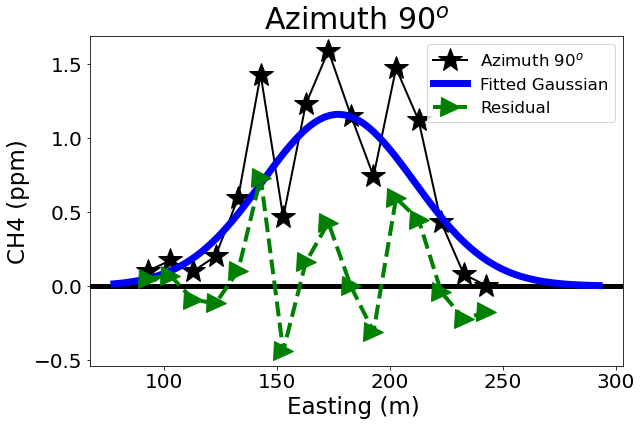

In [71]:
font = {'size'   : 20}
matplotlib.rc('font', **font)
fig, axs = plt.subplots(figsize=(9, 6), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 3, wspace=4)
xx=xrot_90_p
yy=ic_90_p
plt.plot(xx,yy,'k-*',linewidth='2.0',markersize=25,label='Azimuth '+r'$90^{o}$')
plt.xlabel('Easting (m) ',fontsize='23')
plt.ylabel('CH4 (ppm)',fontsize='23') 
plt.axhline(0, ls='-',linewidth=5,color='k')
n=len(xx);mean = sum(xx)/n;sigma=sum(xx-mean)**2/n

# Fit the data using a Gaussian
g_init = models.Gaussian1D(amplitude=0.1, mean=mean, stddev=mean)
fit_g = fitting.LevMarLSQFitter()
g = fit_g(g_init, xx, yy)

# Plot the data with the best-fit model
xx1=np.linspace(min(xx)-15,max(xx)+50, num=100)
plt.plot(xx1, (g(xx1)/max(g(xx1)))*1.16,'b',linewidth=7, label='Fitted Gaussian')

trend=(g(xx)/max(g(xx)))*1.16
detrend=yy-trend
plt.plot(xx,detrend,'g-->',linewidth=4,markersize=19,label='Residual') 
plt.title('Azimuth '+r'$90^{o}$',fontsize='30')
fig.tight_layout(pad=0.5)
plt.legend(loc=1,fontsize='small')
#fig.savefig('fit_Residual_Gaussian.pdf', bbox_inches='tight',dpi=600)
plt.show()

## Variogram (Spatial Correlation) of Residual 

In [72]:
#Normal Score Transformation
columns=['x_','y_','RS']
RS_pd=pd.DataFrame({columns[0]:np.array(xrot_90_p),columns[1]:np.array(yrot_90_p),columns[2]:
                      np.array(detrend)},columns=['x_','y_','RS'])
ns, vr, wt_ns=geostats.nscore(RS_pd, 'RS', wcol=None, ismooth=False, dfsmooth=None, smcol=0, smwcol=0)
RS_pd['NS_RS']=ns

#Experimental Variogram
tmin=-100;tmax=10000;xlag=10;xltol=5;nlag=10;azm=0;atol=90;bandwh=1000;isill=1
Lag1, Var1, npp_az0=geostats.gamv(RS_pd,'x_', 'y_','NS_RS',tmin,tmax,xlag,xltol,nlag,azm,atol,bandwh,isill)

# Fitted variogram Model Parameters
nlag=100; xlag=0.5
vario={'nst':1,'nug':0.01, 'cc1':0.99,'it1':1,'azi1':0,'hmaj1':10,'hmin1':10}
index,Lag1_fit,Var1_fit,cov,ro=geostats.vmodel(nlag, xlag, azm, vario)
clear_output()

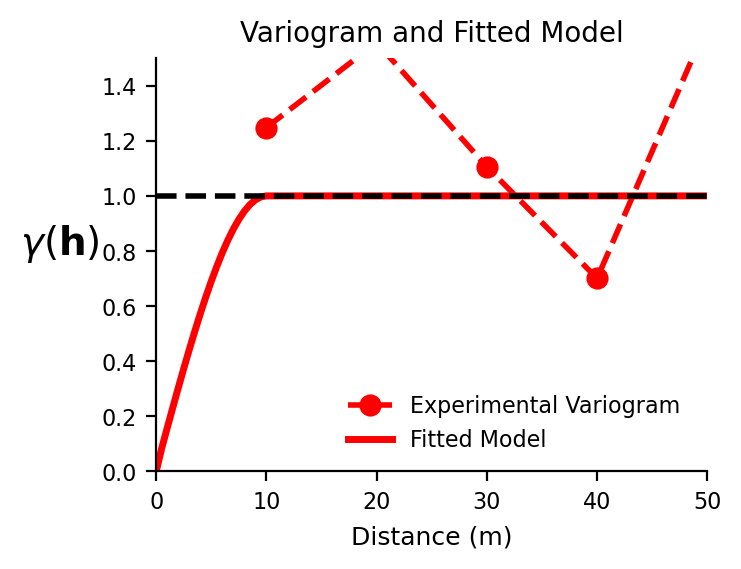

In [73]:
font = {'size'   : 8}
matplotlib.rc('font', **font)
fig, axs = plt.subplots(figsize=(8,6), dpi= 200, facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .05, wspace=0.25) 
#   
#Label and Title of Variogram Plot
label1='Experimental Variogram ' ;symbol1='--or';label1_fit='Fitted Model ';symbol1_fit='-r'
xlabl='Distance (m)'; xlim=[0,50]; vlim=[0,1.5]; sill=1;loc=4

ax1=plt.subplot(1,2,1) 
#Plot Variograms 
Lag1=np.delete(Lag1, np.where(Var1==0))
Var1=np.delete(Var1, np.where(Var1==0))
plt.plot(Lag1, Var1,symbol1,linewidth=2,markersize=7,label=label1)          
plt.plot(Lag1_fit, Var1_fit,symbol1_fit,linewidth=2.5,label=label1_fit) 
plt.legend(fontsize=8,loc=loc,frameon=False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().set_aspect('25')
plt.axhline(y=sill,linewidth=2,color='k',linestyle='--')
title='Variogram and Fitted Model'
plt.title(title,fontsize=10)  
plt.xlabel(xlabl,fontsize=9)
ylabl='$\gamma (\mathbf{h}) $'
plt.ylabel(ylabl,rotation=0,fontsize=14,labelpad=15)
plt.xlim(float(xlim[0]),float(xlim[1]))
plt.ylim(float(vlim[0]),float(vlim[1])) 
plt.show()

## Spatial Bootstrap 

In [74]:
# Calculate spatial bootstrap
detrend_G=np.random.normal(np.mean(detrend),sqrt(np.var(detrend)),1000)
x=RS_pd['x_'].values; y=RS_pd['y_'].values; seed=70; nsim=100
vario={'nst':1,'nug':0.01, 'cc1':0.99,'it1':1,'azi1':0,'hmaj1':10,'hmin1':10}
BS_, BS_m=Spatial_Bootstrap(x, y, detrend_G, vario, seed, nsim,outfl=False)

# Add back trend to the model
BS=[]
for i1 in range(nsim):
    tmp=BS_[i1]+trend
    BS.append(tmp)

 Effective number of data=  13.858105055166437
 Mean of mean= 0.0842 , Variance of the mean =  0.0077


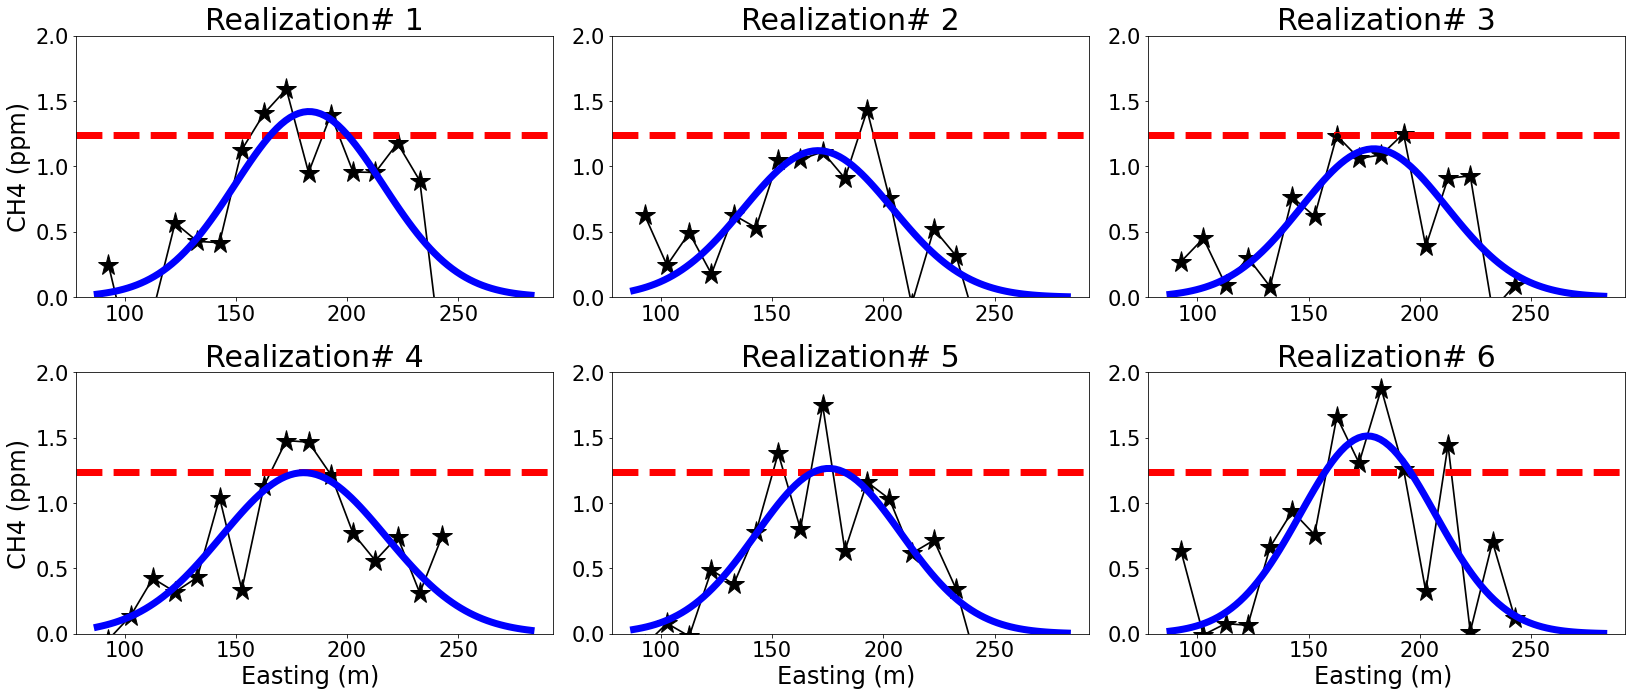

In [75]:
jet= plt.get_cmap('jet')
colors = iter(jet(np.linspace(0,100,115*nsim)))
font = {'size'   : 21}
matplotlib.rc('font', **font)
fig, axs = plt.subplots(figsize=(23, 10), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.35, wspace=0.25)
for isim in range(0,6):
    ax1=plt.subplot(2,3,isim+1)
    plt.plot(xrot_90_p,BS[isim],'k-*',markerfacecolor="k",linewidth='1.7',markersize=22,label='Plume')
    if(isim==3 or isim==4 or isim==5): plt.xlabel('Easting (m) ',fontsize='24')
    if(isim==0 or isim==3):plt.ylabel('CH4 (ppm)',fontsize='24') 
    plt.axhline(fix, ls='--',linewidth=7,color='r')
    xx=xrot_90_p; yy=BS[isim] 
    n=len(xx);mean = sum(xx)/n;sigma=sum(xx-mean)**2/n
    
    # Fit the data using a Gaussian
    g_init = models.Gaussian1D(amplitude=0.1, mean=mean, stddev=mean)
    fit_g = fitting.LevMarLSQFitter()
    g = fit_g(g_init, xx, yy)
    
    # Plot the data with the best-fit model
    plt.plot(xx, yy, 'ko')
    xx1=np.linspace(min(xx)-5,max(xx)+40, num=100)
    plt.plot(xx1, g(xx1),'b',linewidth=7, label='Gaussian')    
    plt.ylim((0, 2))
    plt.title('Realization# '+str(isim+1),fontsize='30')
fig.tight_layout(pad=0.9)    
#fig.savefig('Profile_All_wind_direction.png.pdf',dpi=600)
plt.show()

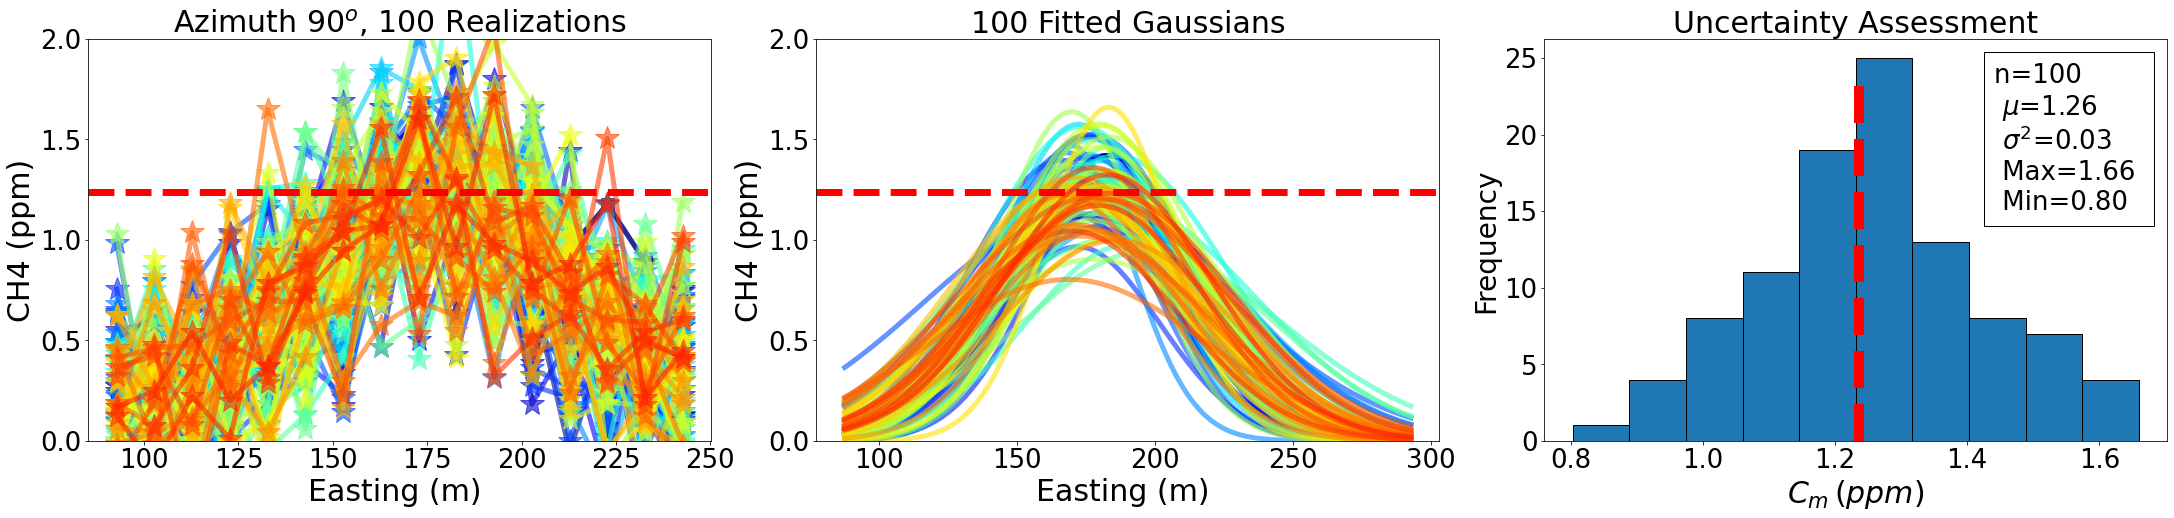

In [76]:
jet= plt.get_cmap('gray')
colors = iter(jet(np.linspace(0,100,180*nsim)))
font = {'size'   : 26}
matplotlib.rc('font', **font)
fig, axs = plt.subplots(figsize=(30, 7), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.1, wspace=0.25)
xx11=[];sim_90_=[];max_=[];Est=[]
for isim in range(nsim):    
    xx=xrot_90_p;yy=BS[isim]
    n=len(xx);mean = sum(xx)/n;sigma=sum(xx-mean)**2/n
    
    # Fit the data using a Gaussian
    g_init = models.Gaussian1D(amplitude=0.1, mean=mean, stddev=mean )
    fit_g = fitting.LevMarLSQFitter()
    g = fit_g(g_init, xx, yy)
    xx1=np.linspace(min(xx)-5,max(xx)+50, num=100)
    if(isim==0): xx11.append(xx1)
    sim_90_.append(g(xx1))
    max_.append(np.max(g(xx1))) 
    Est.append((2*np.pi*5*sigma_y_*sigma_Z_*(16*np.max(g(xx1)/24.45)*10**-3)))
    
ave=[]
for ii in range(len(xx11[0])):
    tmp1=[]
    for isim in range(nsim):
        tmp1.append(sim_90_[isim][ii])
    ave.append(np.mean(tmp1))  
    
jet= plt.get_cmap('jet')
colors = iter(jet(np.linspace(0,100,115*nsim)))    
ax1=plt.subplot(1,3,1)
for isim in range(nsim): 
    if(isim==0):     plt.plot(xrot_90_p,BS[isim],'-s',color=next(colors),
                              linewidth=5,markersize=13,alpha=0.6,label='Simulated Plume')
    plt.plot(xrot_90_p,BS[isim],'-*',color=next(colors),
             linewidth=5,markersize=25,alpha=0.6)
    plt.xlabel('Easting (m) ',fontsize='30')
    plt.ylabel('CH4 (ppm)',fontsize='30') 
    if(isim==nsim-1): plt.axhline(fix, ls='--',linewidth=7,color='r')
    plt.ylim((0, 2))   
    plt.title('Azimuth '+r'$90^{o}$, 100 Realizations',fontsize='30')

ax1=plt.subplot(1,3,2) 
jet= plt.get_cmap('jet')
colors = iter(jet(np.linspace(0,100,115*nsim)))
for isim in range(nsim): 
    if(isim==0): plt.plot(xx11[0], sim_90_[isim],color=next(colors),linewidth=5, label='Fitted Gaussian')   
    plt.plot(xx11[0], sim_90_[isim],color=next(colors),
             markersize=13,linewidth=5,alpha=0.6)     
    if(isim==nsim-1): plt.axhline(fix, ls='--',linewidth=7,color='r',label='Real '+r'$C_{m}$')   
    plt.xlabel('Easting (m) ',fontsize='30')
    plt.ylabel('CH4 (ppm)',fontsize='30')     
    plt.ylim((0, 2))
    plt.title('100 Fitted Gaussians',fontsize='30')     
ax1=plt.subplot(1,3,3)

val=np.array(max_)
plt.hist(val, bins=10,ec='black')      
n=len(val);Mean=np.mean(val);SD=np.var(val) 
Max=np.amax(val);Min=np.amin(val)
txt='n=%.0f \n $\mu$=%.2f \n $\sigma^{2}$=%.2f \n Max=%.2f \n Min=%.2f'
anchored_text = AnchoredText(txt %(n,Mean,SD,Max,Min), loc=1)
ax1.add_artist(anchored_text)
plt.title('Uncertainty Assessment',fontsize='30')    
plt.xlabel(r'$C_{m}\,(ppm)$',fontsize='30')            
plt.ylabel('Frequency',fontsize='28')    
plt.axvline(fix,ymin=0, ymax=0.90, ls='--',linewidth=10.0,color='r')

fig.tight_layout(pad=0)
#fig.savefig('Result_wind_direction.pdf',dpi=600)
plt.show()

# Correlation of Variables

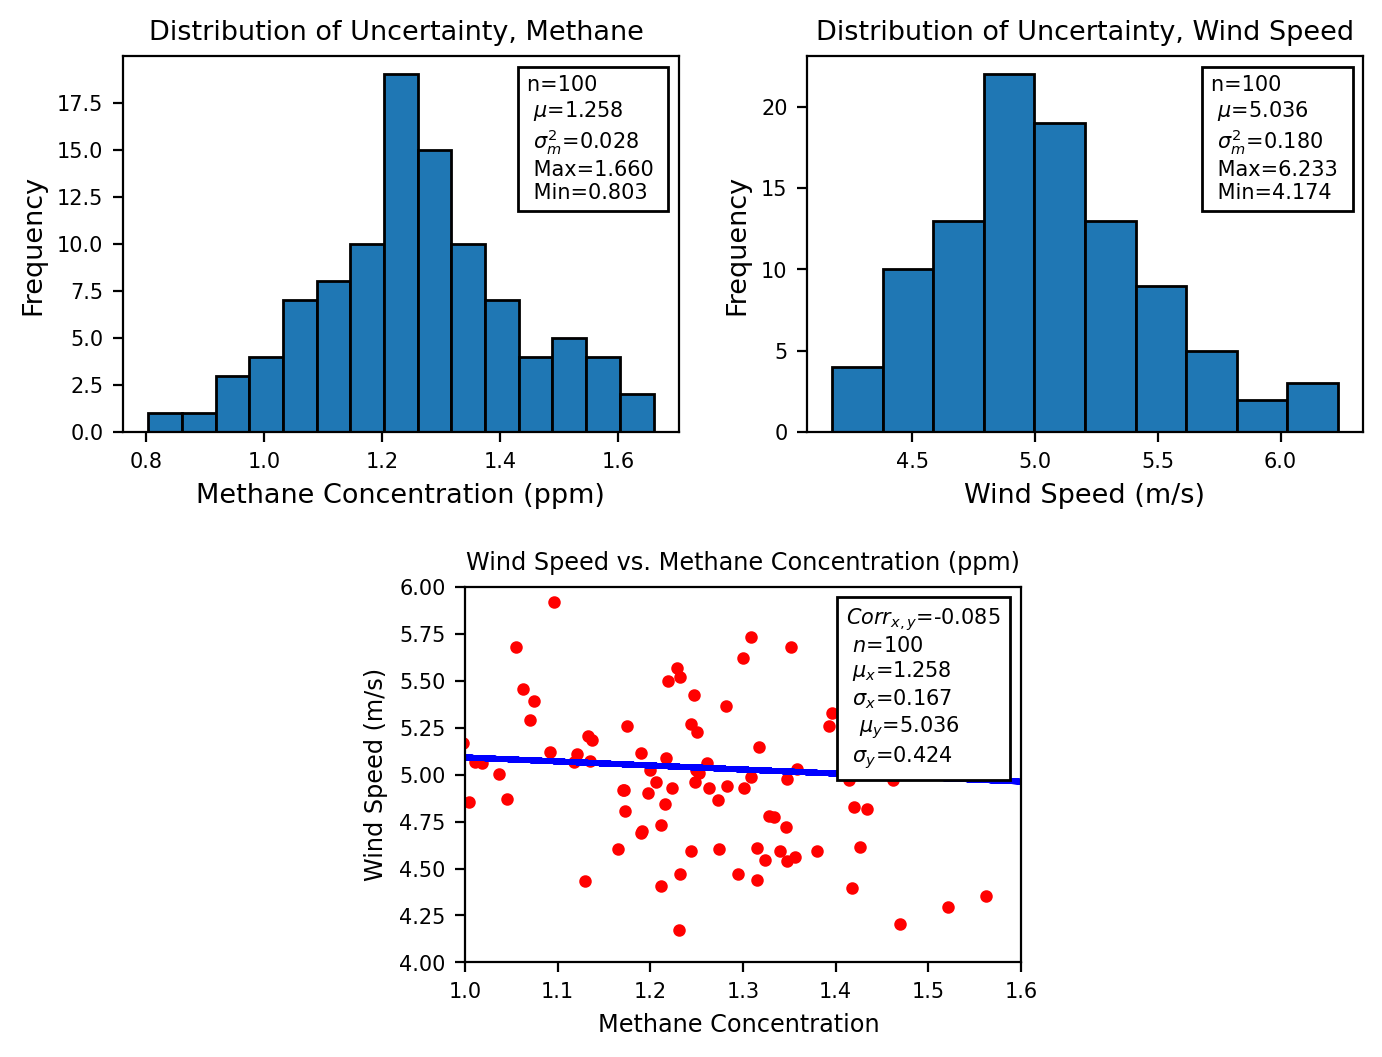

In [94]:
random.seed(42)
font = {'size'   :7.5 }
matplotlib.rc('font', **font)
fig=plt.figure(figsize=(8, 6), dpi= 200, facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 1.4, wspace=.6)
gs = gridspec.GridSpec(4, 4)
ax1 = plt.subplot(gs[:2, :2])
histplt1 (max_,15,title='Distribution of Uncertainty, Methane ',xlabl='Methane Concentration (ppm)',xlimt=None,ylimt=None,axt=ax1)
ax2 = plt.subplot(gs[:2, 2:])
histplt1 (BS_m_46,10,title='Distribution of Uncertainty, Wind Speed',xlabl='Wind Speed (m/s)',xlimt=None,ylimt=None,axt=ax2)
ax3 = plt.subplot(gs[2:4, 1:3])
CrossPlot(max_,BS_m_46,title='Wind Speed vs. Methane Concentration (ppm)',xlabl='Methane Concentration ',
          ylabl='Wind Speed (m/s)',loc=1,xlimt=(1.0,1.6),
          ylimt=(4,6),masiz=3.5,axt=ax3)

In [82]:
#random.seed(42)
import pprint
import scipy
import scipy.linalg   # 
matrix=np.zeros((2,2))
matrix[0,0]=1;matrix[0,1]=-0.72
matrix[1,0]=-0.72;matrix[1,1]=1
L=scipy.linalg.cholesky(matrix, lower=True, overwrite_a=True)
mu=0; sigma=1
w=np.zeros((2,nsim))
Dist1 = np.random.normal(mu, sigma, nsim)
w[0,:]=Dist1
Dist2 = np.random.normal(mu, sigma, nsim)
w[1,:]=Dist2

N_WS=[];N_CM=[]
for i in range(nsim):
    tmp=(np.matmul(L,w[:,i]))
    N_WS.append(tmp[0])
    N_CM.append(tmp[1])  

R_WS=[];R_CM=[]

tmp1=np.sort(N_WS)
tmp1_1=np.sort(BS_m_46)
R_WS=np.zeros((len(N_WS)))
for i in range(len(N_WS)):
    index1=np.where(N_WS==tmp1[i])
    index2=np.where(BS_m_46==tmp1_1[i])    
    R_WS[index1[0][0]]=BS_m_46[index2[0][0]]
#
tmp1=np.sort(N_CM)
tmp1_1=np.sort(max_)
R_CM=np.zeros((len(N_CM)))
for i in range(len(N_CM)):
    index1=np.where(N_CM==tmp1[i])
    index2=np.where(max_==tmp1_1[i])    
    R_CM[index1[0][0]]=max_[index2[0][0]]
   

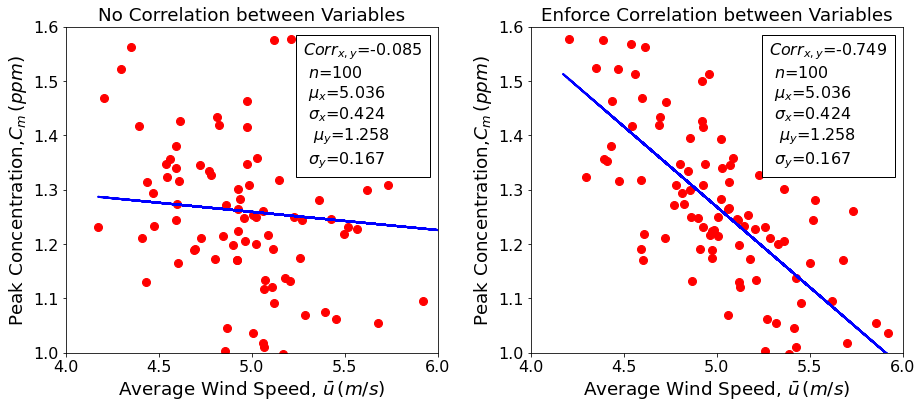

In [98]:

jet= plt.get_cmap('jet')
colors = iter(jet(np.linspace(0,100,115*nsim)))

font = {'size'   : 16}
matplotlib.rc('font', **font)

fig, axs = plt.subplots(figsize=(15, 6), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.1, wspace=0.25)
#
alpha_=[1-i/nsim  for i in range(nsim)]

ax1=plt.subplot(1,2,1)
CrossPlot(BS_m_46,max_,title='No Correlation between Variables',xlabl='Average Wind Speed, '+ r'$\bar{u}\,(m/s)$',
          ylabl='Peak Concentration,'+ r'$C_{m}\,(ppm)$' ,loc=1,ylimt=(1.0,1.6),
          xlimt=(4,6),masiz=8,axt=ax1)
ax1=plt.subplot(1,2,2)
CrossPlot(R_WS,R_CM,title='Enforce Correlation between Variables',xlabl='Average Wind Speed, '+ r'$\bar{u}\,(m/s)$',
          ylabl='Peak Concentration,'+ r'$C_{m}\,(ppm)$' ,loc=1,ylimt=(1.0,1.6),
          xlimt=(4,6),masiz=8,axt=ax1)
fig.savefig('corr.pdf', bbox_inches='tight',dpi=600)

# Final Estimation of Emission Rate with Uncertainty Assessment

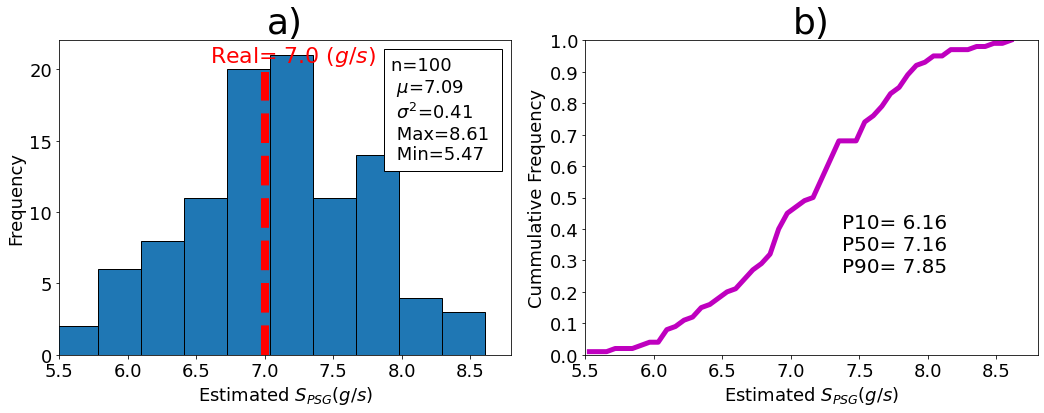

In [89]:
jet= plt.get_cmap('gray')
colors = iter(jet(np.linspace(0,100,180*nsim)))
font = {'size'   : 18}
matplotlib.rc('font', **font)
fig, axs = plt.subplots(figsize=(15, 6), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.1, wspace=0.25) 
Est=[]
for isim in range(nsim):    
    Est.append((2*np.pi*R_WS[isim]*sigma_y_*sigma_Z_*(16*R_CM[isim]/24.45)*10**-3))
ax1=plt.subplot(1,2,1)
val=np.array(Est)
plt.hist(val, bins=10,ec='black')      
n=len(val)
Mean=np.mean(val)
SD=np.var(val) 
Max=np.amax(val)
Min=np.amin(val)
txt='n=%.0f \n $\mu$=%.2f \n $\sigma^{2}$=%.2f \n Max=%.2f \n Min=%.2f'
anchored_text = AnchoredText(txt %(n,Mean,SD,Max,Min), loc=1)
ax1.add_artist(anchored_text)
plt.title('a)',fontsize='36')    
plt.xlabel('Estimated '+ r'$S_{PSG}(g/s)$',fontsize='18')            
plt.ylabel('Frequency',fontsize='18')    
plt.axvline(7,ymin=0, ymax=0.90, ls='--',linewidth=8,color='r')
plt.xlim((5.5, 8.8))   
plt.annotate(s='Real= %.1f' %(7)+' $(g/s)$',
                 xy=(7,11),color='r',xytext=(6.6,20.5),fontsize='22')
ax1=plt.subplot(1,2,2)
counts, bin_edges = np.histogram(Est, bins=50,density=True)
cdf = np.cumsum(counts)
tmp=max(cdf)
cdf=cdf/float(tmp)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.plot(bin_edges[1:], cdf,color="m",linewidth='5')
plt.xlabel('Estimated '+ r'$S_{PSG} (g/s)$',fontsize='18')
plt.ylabel('Cummulative Frequency',fontsize='18')

val=min(cdf, key=lambda x:abs(x-0.1))
aa=np.where(cdf == val)
txt= 'P10= '
txt+='{0:.2f}'.format(float(bin_edges[int(aa[0][0]+1)]))
txt+= '\n'
val=min(cdf, key=lambda x:abs(x-0.5))
aa=np.where(cdf == val)
txt+= 'P50= '
txt+='{0:.2f}'.format(float(bin_edges[int(aa[0][0]+1)]))
txt+= '\n'
val=min(cdf, key=lambda x:abs(x-0.9))
aa=np.where(cdf == val)
txt+= 'P90= '
txt+='{0:.2f}'.format(float(bin_edges[int(aa[0][0]+1)]))
plt.ylim((0, 1))
plt.text(0.80, 0.35, txt, ha='right', horizontalalignment='center',verticalalignment='center',
         transform=ax1.transAxes,fontsize='20')
plt.title('b)',fontsize='36')
plt.xlim((5.5, 8.8))  
fig.tight_layout(pad=0.9)     
#fig.savefig('Final_Result.pdf', bbox_inches='tight',dpi=600)
plt.show()